# Benchmarking Harpia Module for Annotat3d Image Processing and Segmentation

This notebook benchmarks the **Harpia module**, the backend engine for Annotat3d, a tool designed for advanced image processing and segmentation tasks. The benchmarking process evaluates two key performance metrics:

1. **Accuracy**: Compares the results of Harpia’s image processing and segmentation functions with standard open-source tools like `scikit-image`, ensuring reliability and accuracy that meet industry standards.

2. **Execution Time**: Assesses runtime efficiency by measuring the execution times of Harpia’s functions relative to baseline tools, especially when handling large or complex images.

The benchmark is conducted on both **2D and 3D images** of various sizes, including very large images, to reflect Sirius demands in high-resolution and volumetric data efficient processing. This notebook provides a step-by-step analysis, including data setup, function execution, and results comparison, to evaluate Harpia's capability to handle a range of image dimensions and formats.


## Framework

In [57]:
import os
import numpy as np
import pandas as pd
from pandas.plotting import table
import glob
import matplotlib.pyplot as plt
import seaborn as sns

def read_csv_files(path):
    # Get the current working directory
    print("Searching in:", path)

    # Recursively find all CSV files in subdirectories
    csv_files = glob.glob(os.path.join(path, "**", "*.csv"), recursive=True)

    if not csv_files:
        print("No CSV files found.")
        return None

    # Read all CSV files into a list of DataFrames
    dfs = [pd.read_csv(file) for file in csv_files]

    # Optionally, concatenate all DataFrames into one
    df_all = pd.concat(dfs, ignore_index=True)

    print(f"Loaded {len(csv_files)} CSV files.")
    return df_all


In [2]:
def filter_dataframe(df, filters):
    """
    Filters the DataFrame based on the specified filters.

    Parameters:
    - df (pd.DataFrame): The DataFrame to filter.
    - filters (dict): A dictionary where the key is the column name and the value is the value to filter by.

    Returns:
    - pd.DataFrame: The filtered DataFrame (original remains unchanged).
    """
    filtered_df = df.copy()
    for col, value in filters.items():
        filtered_df = filtered_df[filtered_df[col] == value]
    return filtered_df


In [183]:
def save_df_as_image(df, filename='df_image.png', dpi=300, show_index=True):
    """
    Saves a DataFrame as a well-formatted image file.

    Parameters:
    - df (pd.DataFrame): The DataFrame to save.
    - filename (str): The output filename (PNG).
    - dpi (int): Resolution in dots per inch.
    - show_index (bool): Whether to display the index in the image. Default is True.
    """
   # Create a copy to avoid modifying the original DataFrame
    display_df = df.copy()
    
    # If the index should not be displayed, remove it
    if not show_index:
        display_df.index = [''] * len(display_df)
    
    # Determine the figure size based on DataFrame dimensions
    fig_width = min(20, max(6, 0.2 * display_df.shape[1]))  # Scale width by number of columns
    fig_height = min(40, max(4, 0.4 * display_df.shape[0])) # Scale height by number of rows
    
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.axis('off')  # Hide the axis
    mpl_table = table(ax, display_df, loc='center', cellLoc='center', colWidths=[0.2]*len(display_df.columns))
    
    # Formatting for better readability
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(10)
    mpl_table.auto_set_column_width(col=list(range(len(display_df.columns))))  # Auto-adjust column width
    
    # Remove extra padding around the table
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    
    # Get the bounding box of the table and adjust the figure size
    renderer = fig.canvas.get_renderer()
    bbox = mpl_table.get_window_extent(renderer=renderer)
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    
    # Save the image, tightly cropped to the table's exact size
    output_path = filename
    plt.savefig(output_path, bbox_inches=bbox, pad_inches=0, dpi=dpi)
    plt.close(fig)
    print(output_path)
    return output_path

In [3]:
current_dir = os.getcwd()
df_cython1 = read_csv_files(current_dir+"/results_old/")
df_cython2 = read_csv_files(current_dir+"/results_cython/")
df_cuda = read_csv_files(current_dir+"/results_cuda/")

Searching in: /ibira/lnls/labs/tepui/home/camila.araujo/work/harpia/tests_python/benchmark/results_old/
Loaded 219 CSV files.
Searching in: /ibira/lnls/labs/tepui/home/camila.araujo/work/harpia/tests_python/benchmark/results_cython/
Loaded 4 CSV files.
Searching in: /ibira/lnls/labs/tepui/home/camila.araujo/work/harpia/tests_python/benchmark/results_cuda/
Loaded 10 CSV files.


In [4]:
df_cython1[pd.isna(df_cython1['Scikit-Image Time (s)'])]

Operation  Machine  Gpus  gpuMemory  Module Time (s)  \
0        Erosion 3D binary  harriet     1       0.41        10.543490   
1        Opening 3D binary  harriet     1       0.30        12.143514   
2        Opening 3D binary  harriet     1       0.41        30.914311   
3        Erosion 3D binary  harriet     1       0.30        20.169935   
4       Dilation 3D binary  harriet     1       0.30        20.176295   
..                     ...      ...   ...        ...              ...   
208  Dilation 3D grayscale  harriet     4       0.20        19.055792   
209     Dilation 3D binary  harriet     4       0.20        10.048981   
217    Smoothing 3D binary  harriet     4       0.20        12.029979   
220      Closing 3D binary  harriet     4       0.20        19.899343   
221   Closing 3D grayscale  harriet     4       0.20        22.451185   

     Scikit-Image Time (s)  Time Ratio  Repetitions  Mean Squared Error  \
0                      NaN         NaN           10                 NaN   
1                      NaN         NaN           10                 NaN   
2                      NaN         NaN           10                 NaN   
3                      NaN         NaN           10                 NaN   
4                      NaN         NaN           10                 NaN   
..                     ...         ...          ...                 ...   
208                    NaN         NaN           10                 NaN   
209                    NaN         NaN           10                 NaN   
217                    NaN         NaN           10                 NaN   
220                    NaN         NaN           10                 NaN   
221                    NaN         NaN           10                 NaN   

     Pixel Accuracy (%) Image Data Type  Image Size (MB)    Image Dimensions  
0                   NaN           int32          31424.0  (1964, 2048, 2048)  
1                   NaN           int16          15712.0  (1964, 2048, 2048)  
2                   NaN           int32          31424.0  (1964, 2048, 2048)  
3                   NaN          uint32          31424.0  (1964, 2048, 2048)  
4                   NaN          uint32          31424.0  (1964, 2048, 2048)  
..                  ...             ...              ...                 ...  
208                 NaN          uint32          32896.1  (2048, 2052, 2052)  
209                 NaN          uint16          16448.1  (2048, 2052, 2052)  
217                 NaN           int16          16448.1  (2048, 2052, 2052)  
220                 NaN          uint32          32896.1  (2048, 2052, 2052)  
221                 NaN         float32          32896.1  (2048, 2052, 2052)  

[75 rows x 13 columns]

## First Tests

Primeiros testes realizados em cython

Preparar repositório para salvar imagens de saída

In [5]:
save = True #wheter to save the plots as figures
notebook_name = "benchmark_read/first_tests"
output_dir = f"{notebook_name}_plots"
os.makedirs(output_dir, exist_ok=True)
print(f"Plots will be saved to: {output_dir}")

Plots will be saved to: benchmark_read/first_tests_plots


In [6]:
current_dir = os.getcwd()
df_cython1 = read_csv_files(current_dir+"/results_old/")

Searching in: /ibira/lnls/labs/tepui/home/camila.araujo/work/harpia/tests_python/benchmark/results_old/
Loaded 219 CSV files.


#### Corrigir dimensão errada das imagens

In [7]:
df_cython1['Image Dimensions'].unique()

array(['(1964, 2048, 2048)', '(1520, 1520, 600)', '(100, 207, 190)',
       '(2048, 2052, 2052)'], dtype=object)

In [8]:
df_cython1['Image Dimensions'] = df_cython1['Image Dimensions'].replace('(2048, 2052, 2052)', '(2052, 2052, 2048)')

In [9]:
df_cython1['Image Dimensions'].unique()

array(['(1964, 2048, 2048)', '(1520, 1520, 600)', '(100, 207, 190)',
       '(2052, 2052, 2048)'], dtype=object)

#### Visualizar dados grandes e pequenos

In [10]:
filter_dataframe(df_cython1, {'Image Dimensions': '(2052, 2052, 2048)'}).head(5)

Operation  Machine  Gpus  gpuMemory  Module Time (s)  \
120      Closing 3D binary  harriet     1        0.2        28.519186   
121      Erosion 3D binary  harriet     2        0.2        14.796998   
122   Erosion 3D grayscale  harriet     2        0.2         9.104506   
123  Dilation 3D grayscale  harriet     4        0.2        18.454371   
124     Dilation 3D binary  harriet     1        0.2         6.069428   

     Scikit-Image Time (s)  Time Ratio  Repetitions  Mean Squared Error  \
120             339.915684        11.9           10                 0.0   
121             155.746572        10.5           10                 0.0   
122             268.842347        29.5           10                 0.0   
123                    NaN         NaN           10                 NaN   
124             142.815209        23.5           10                 0.0   

     Pixel Accuracy (%) Image Data Type  Image Size (MB)    Image Dimensions  
120               100.0          uint32          32896.1  (2052, 2052, 2048)  
121               100.0           int16          16448.1  (2052, 2052, 2048)  
122               100.0         float32          32896.1  (2052, 2052, 2048)  
123                 NaN         float32          32896.1  (2052, 2052, 2048)  
124               100.0           int16          16448.1  (2052, 2052, 2048)

In [11]:
filter_dataframe(df_cython1, {'Image Dimensions': '(100, 207, 190)'}).head(5)

Operation  Machine  Gpus  gpuMemory  Module Time (s)  \
36   Smoothing 3D binary  harriet     1        0.2         0.010380   
37     Opening 3D binary  harriet     1        0.2         0.004046   
38     Opening 3D binary  harriet     1        0.2         0.004510   
39  Erosion 3D grayscale  harriet     1        0.2         0.005448   
40     Erosion 3D binary  harriet     2        0.2         0.004184   

    Scikit-Image Time (s)  Time Ratio  Repetitions  Mean Squared Error  \
36               0.226694        21.8           10                 0.0   
37               0.086353        21.3           10                 0.0   
38               0.088112        19.5           10                 0.0   
39               0.107222        19.7           10                 0.0   
40               0.043281        10.3           10                 0.0   

    Pixel Accuracy (%) Image Data Type  Image Size (MB) Image Dimensions  
36               100.0          uint32             15.0  (100, 207, 190)  
37               100.0           uint8              3.8  (100, 207, 190)  
38               100.0            int8              3.8  (100, 207, 190)  
39               100.0          uint32             15.0  (100, 207, 190)  
40               100.0          uint16              7.5  (100, 207, 190)

### Clean dataframe

In [12]:
df_cython1.columns

Index(['Operation', 'Machine', 'Gpus', 'gpuMemory', 'Module Time (s)',
       'Scikit-Image Time (s)', 'Time Ratio', 'Repetitions',
       'Mean Squared Error', 'Pixel Accuracy (%)', 'Image Data Type',
       'Image Size (MB)', 'Image Dimensions'],
      dtype='object')

In [13]:
print(df_cython1.isna().sum())

Operation                 0
Machine                   0
Gpus                      0
gpuMemory                 0
Module Time (s)           0
Scikit-Image Time (s)    75
Time Ratio               75
Repetitions               0
Mean Squared Error       75
Pixel Accuracy (%)       75
Image Data Type           0
Image Size (MB)           0
Image Dimensions          0
dtype: int64


#### Fill NaN 'Scikit-Image Time (s)'
Preencher as colunas que não possuem o tempo de execução no scikit image com a média do cálculo já feito para a mesma imagem e mesmo tamanho em outros casos.

In [14]:
print(df_cython1[['Scikit-Image Time (s)']].isna().sum())

Scikit-Image Time (s)    75
dtype: int64


In [15]:
df_cython1['Scikit-Image Time (s)'] = df_cython1['Scikit-Image Time (s)'].fillna(
    df_cython1.groupby(['Image Data Type', 'Image Size (MB)', 'Image Dimensions'])['Scikit-Image Time (s)'].transform('mean')
)

In [16]:
print(df_cython1[['Scikit-Image Time (s)']].isna().sum())

Scikit-Image Time (s)    36
dtype: int64


In [17]:
df_cython1 = df_cython1.dropna(subset=['Scikit-Image Time (s)'])

In [18]:
print(df_cython1[['Scikit-Image Time (s)']].isna().sum())

Scikit-Image Time (s)    0
dtype: int64


#### Fill NaN 'Time Ratio'
 
Preencher o 'time ratio' aproximado para as funções que não calcularam concomitnatemente o resultado do scikit image

In [19]:
print(df_cython1[['Time Ratio']].isna().sum())

Time Ratio    39
dtype: int64


In [20]:
df_cython1['Time Ratio'] = df_cython1['Time Ratio'].fillna(df_cython1['Scikit-Image Time (s)'] / df_cython1['Module Time (s)'])

In [21]:
print(df_cython1[['Time Ratio']].isna().sum())

Time Ratio    0
dtype: int64


#### Create 'xsize', 'ysize' e 'zsize'
Preencher as colunas xsize, ysize e zsize para compatibilizar com o df_cuda

In [22]:
df_cython1[['xsize', 'ysize', 'zsize']] = pd.DataFrame(
    df_cython1['Image Dimensions'].apply(lambda x: list(map(int, eval(x)))).tolist(),
    index=df_cython1.index
) #compatibilizar com df_cuda

#### Compatibilizar 'Image Size (MB)'

Compatibilizar com resultados dos testes me cuda

In [23]:
df_cython1['Image Size (MB)'] = df_cython1['Image Size (MB)'].apply(lambda x: round(x, 1))  #compatibilizar com df_cuda

In [24]:
df_cython1.head(5)

Operation  Machine  Gpus  gpuMemory  Module Time (s)  \
36   Smoothing 3D binary  harriet     1        0.2         0.010380   
37     Opening 3D binary  harriet     1        0.2         0.004046   
38     Opening 3D binary  harriet     1        0.2         0.004510   
39  Erosion 3D grayscale  harriet     1        0.2         0.005448   
40     Erosion 3D binary  harriet     2        0.2         0.004184   

    Scikit-Image Time (s)  Time Ratio  Repetitions  Mean Squared Error  \
36               0.226694        21.8           10                 0.0   
37               0.086353        21.3           10                 0.0   
38               0.088112        19.5           10                 0.0   
39               0.107222        19.7           10                 0.0   
40               0.043281        10.3           10                 0.0   

    Pixel Accuracy (%) Image Data Type  Image Size (MB) Image Dimensions  \
36               100.0          uint32             15.0  (100, 207, 190)   
37               100.0           uint8              3.8  (100, 207, 190)   
38               100.0            int8              3.8  (100, 207, 190)   
39               100.0          uint32             15.0  (100, 207, 190)   
40               100.0          uint16              7.5  (100, 207, 190)   

    xsize  ysize  zsize  
36    100    207    190  
37    100    207    190  
38    100    207    190  
39    100    207    190  
40    100    207    190

#### Final cleanned df

In [25]:
print(df_cython1.isna().sum())

Operation                 0
Machine                   0
Gpus                      0
gpuMemory                 0
Module Time (s)           0
Scikit-Image Time (s)     0
Time Ratio                0
Repetitions               0
Mean Squared Error       39
Pixel Accuracy (%)       39
Image Data Type           0
Image Size (MB)           0
Image Dimensions          0
xsize                     0
ysize                     0
zsize                     0
dtype: int64


Os valores NaN para 'Mean Squared Error' e 'Pixel Accuracy (%)' são decorrentes de experimentos em que não se executou a versão de controle do scikit-image e comparou-se o resultado com o da harpia. O tempo de execuçõa foi preenchido com o tmepo médio para aquela operação em outras execuções para a mesma imagem, mas não foi feita a verificação pixel a pixel. Isso não é um problema para as analizes subsequentes.

### plots
Mostrar tempo de execução na harriet apenas, para as imagens muito grandes

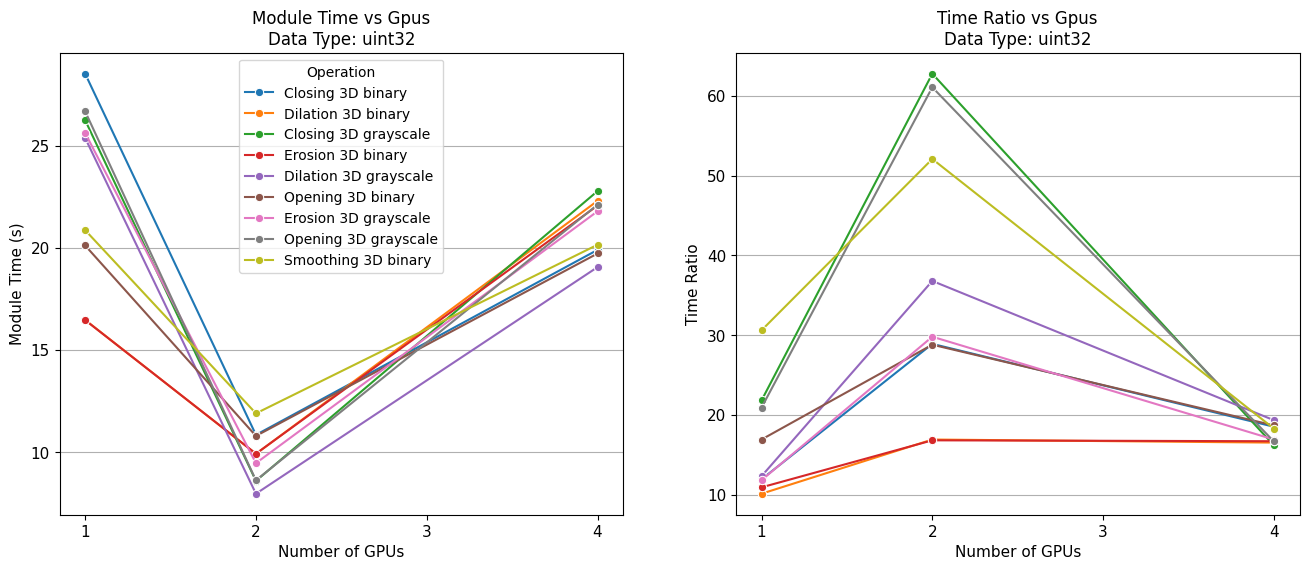

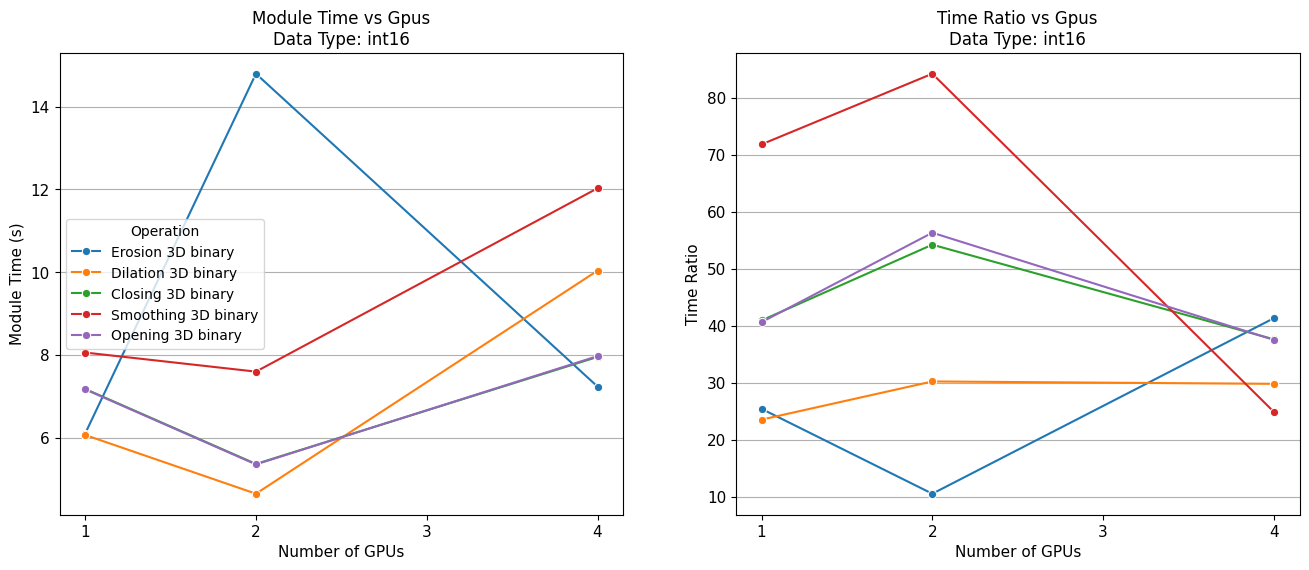

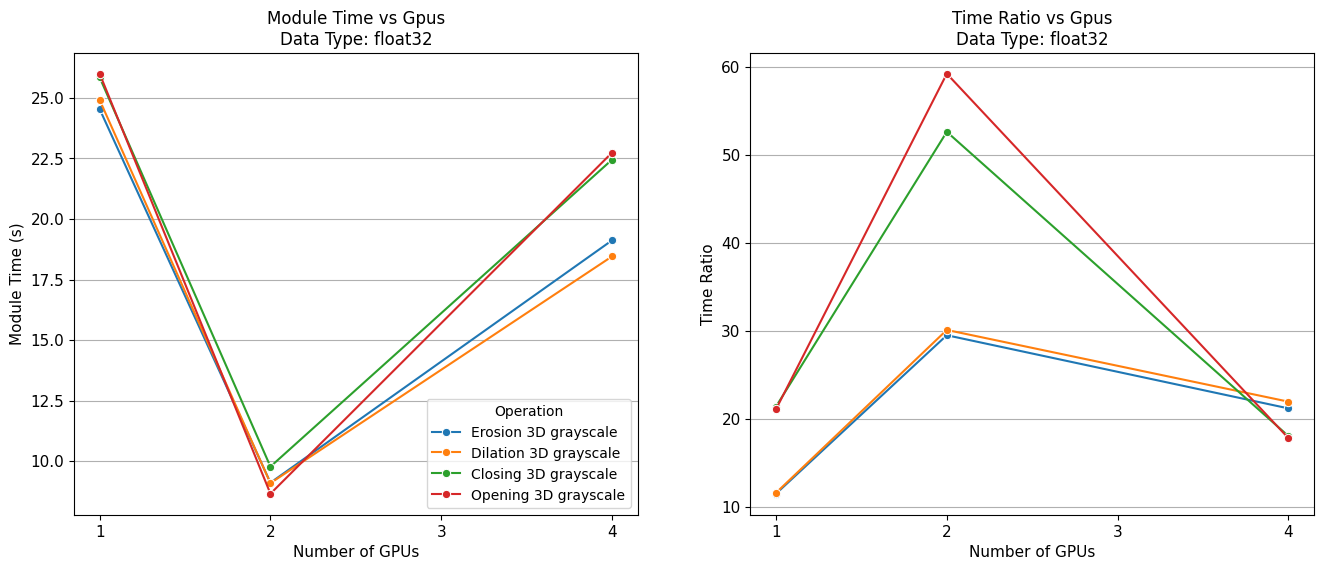

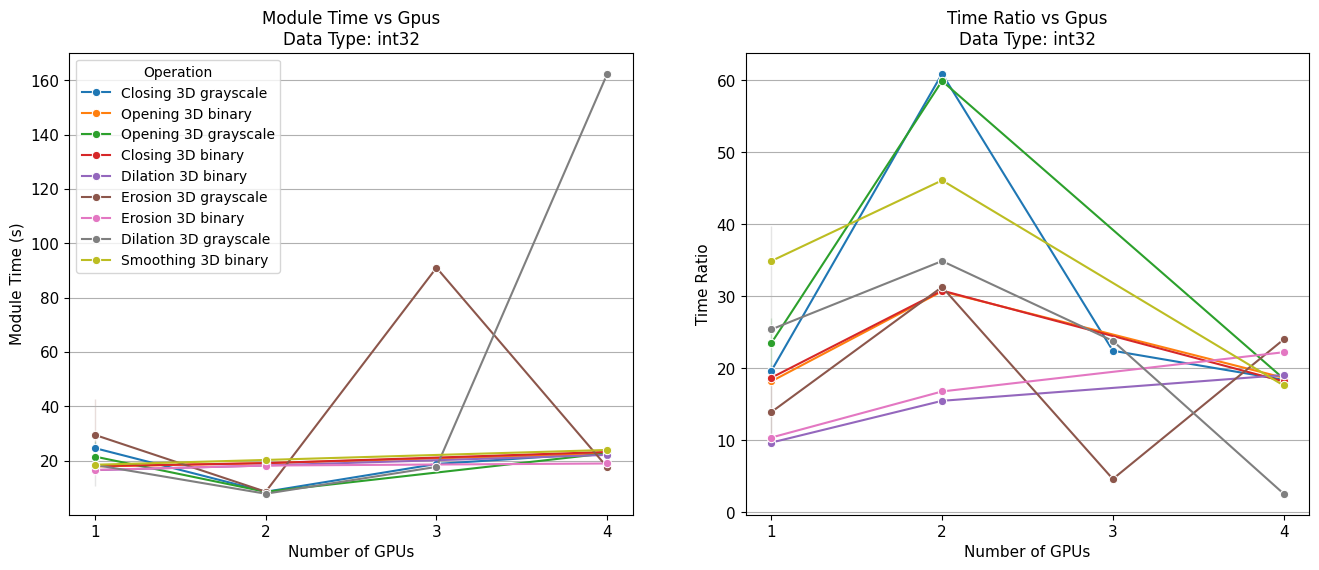

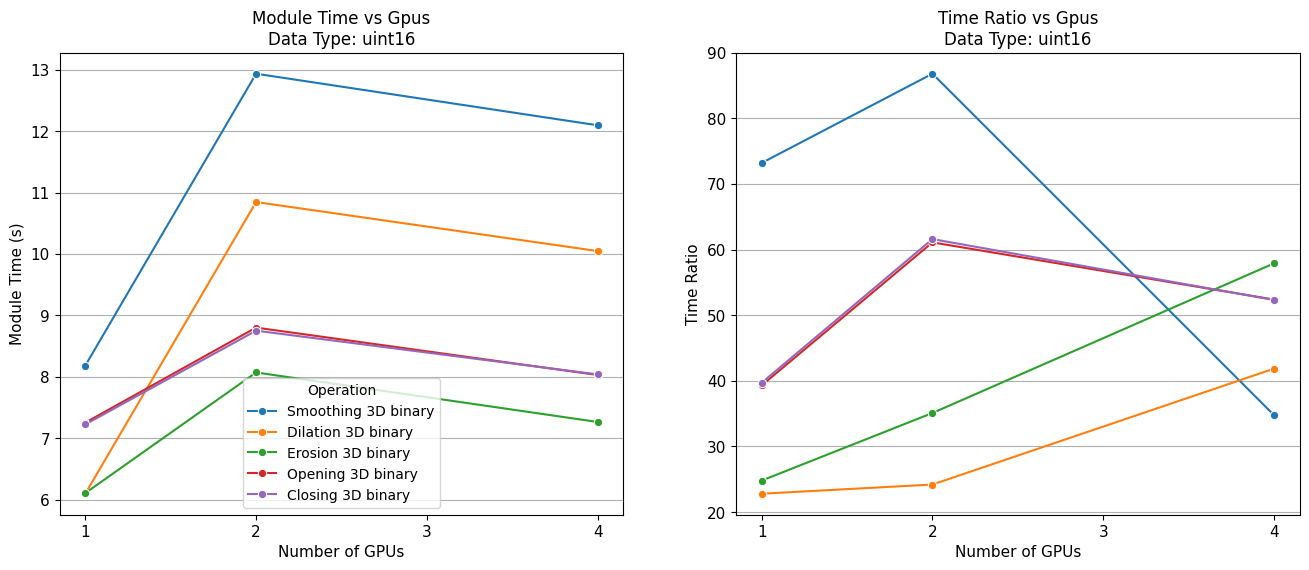

In [26]:
# Filter for huge images
img_dim =  '(2052, 2052, 2048)'
df_huge = filter_dataframe(df_cython1, {'Image Dimensions': img_dim})
# Get unique values of 'Image Dimensions' and 'Image Data Type'
image_dims = df_huge['Image Dimensions'].unique()
data_types = df_huge['Image Data Type'].unique()

# Get unique GPU values sorted
gpu_ticks = sorted(df_huge['Gpus'].unique())

# Define font size for ticks
FONT_SIZE = 11  

for dtype in data_types:
    subset = filter_dataframe(df_huge, 
                              {'Image Dimensions': img_dim, 
                               'Image Data Type':dtype})
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Side-by-side layout

    # First plot: Module Time vs GPUs
    sns.lineplot(data=subset, x='Gpus', y='Module Time (s)', hue='Operation', marker='o', ax=axes[0])
    axes[0].set_title(f"Module Time vs Gpus\nData Type: {dtype}", fontsize=FONT_SIZE+1)
    axes[0].set_xlabel("Number of GPUs", fontsize=FONT_SIZE)
    axes[0].set_ylabel("Module Time (s)", fontsize=FONT_SIZE)
    axes[0].legend(title="Operation", fontsize=FONT_SIZE - 1)
    axes[0].set_xticks(gpu_ticks)

    # Second plot: Time Ratio vs GPUs (without legend)
    sns.lineplot(data=subset, x='Gpus', y='Time Ratio', hue='Operation', marker='o', ax=axes[1])
    axes[1].set_title(f"Time Ratio vs Gpus\nData Type: {dtype}", fontsize=FONT_SIZE+1)
    axes[1].set_xlabel("Number of GPUs", fontsize=FONT_SIZE)
    axes[1].set_ylabel("Time Ratio", fontsize=FONT_SIZE)
    axes[1].set_xticks(gpu_ticks)
    axes[1].get_legend().remove()
    
    # Set font size for x and y ticks
    for ax in axes:
        ax.tick_params(axis='both', labelsize=FONT_SIZE)  # Increase font size
        ax.yaxis.grid(True)  # Keep only horizontal grid lines
        ax.xaxis.grid(False)  # Remove vertical grid lines

    # Save the figure
    filename = f"{output_dir}/benchmark_plot_{dtype.replace(' ', '_')}.png"
    if(save): plt.savefig(filename, dpi=300, bbox_inches='tight')  # High-quality save
        
plt.show()

## Cyhton test

In [27]:
save = True #wheter to save the plots as figures
notebook_name = "benchmark_read/Cython"
output_dir = f"{notebook_name}_plots"
os.makedirs(output_dir, exist_ok=True)
print(f"Plots will be saved to: {output_dir}")

Plots will be saved to: benchmark_read/Cython_plots


In [28]:
current_dir = os.getcwd()
df_cython2 = read_csv_files(current_dir+"/results_cython/")
df_cython2 = df_cython2.dropna(axis=1, how='all') #eliminar colunas não preenchidas
df_cython2 = filter_dataframe(df_cython2, {'Repetitions': 20}) #eliminate 'read_input' timing


Searching in: /ibira/lnls/labs/tepui/home/camila.araujo/work/harpia/tests_python/benchmark/results_cython/
Loaded 4 CSV files.


In [120]:
df_cython2

Operation  Machine  Gpus  gpuMemory  Module Time (s)  \
0     Erosion 3D grayscale  harriet     1        0.1        18.212188   
1    Dilation 3D grayscale  harriet     1        0.1         9.407168   
2     Closing 3D grayscale  harriet     1        0.1        11.028709   
3     Opening 3D grayscale  harriet     1        0.1        10.958756   
4     Top Hat 3D grayscale  harriet     1        0.1        11.084696   
..                     ...      ...   ...        ...              ...   
370      Erosion 3D binary  harriet     2        0.4        15.105242   
371     Dilation 3D binary  harriet     2        0.4        17.645449   
372      Closing 3D binary  harriet     2        0.4        22.015264   
373      Opening 3D binary  harriet     2        0.4        23.890984   
374    Smoothing 3D binary  harriet     2        0.4        25.301464   

     Repetitions Image Data Type  Image Size (MB)    Image Dimensions  xsize  \
0             20           int32          32896.1  (2052, 2052, 2048)   2052   
1             20           int32          32896.1  (2052, 2052, 2048)   2052   
2             20           int32          32896.1  (2052, 2052, 2048)   2052   
3             20           int32          32896.1  (2052, 2052, 2048)   2052   
4             20           int32          32896.1  (2052, 2052, 2048)   2052   
..           ...             ...              ...                 ...    ...   
370           20           int32          32896.1  (2052, 2052, 2048)   2052   
371           20           int32          32896.1  (2052, 2052, 2048)   2052   
372           20           int32          32896.1  (2052, 2052, 2048)   2052   
373           20           int32          32896.1  (2052, 2052, 2048)   2052   
374           20           int32          32896.1  (2052, 2052, 2048)   2052   

     ysize  zsize  
0     2052   2048  
1     2052   2048  
2     2052   2048  
3     2052   2048  
4     2052   2048  
..     ...    ...  
370   2052   2048  
371   2052   2048  
372   2052   2048  
373   2052   2048  
374   2052   2048  

[353 rows x 12 columns]

#### Create 'xsize', 'ysize' e 'zsize'
Preencher as colunas xsize, ysize e zsize para compatibilizar com o df_cuda

In [29]:
df_cython2[['xsize', 'ysize', 'zsize']] = pd.DataFrame(
    df_cython2['Image Dimensions'].apply(lambda x: list(map(int, eval(x)))).tolist(),
    index=df_cython2.index
)

#### Compatibilizar 'Image Size (MB)'

Compatibilizar com resultados dos testes me cuda

In [30]:
df_cython2['Image Size (MB)'] = df_cython2['Image Size (MB)'].apply(lambda x: round(x, 1))  #compatibilizar com df_cuda

In [31]:
df_cython2

Operation  Machine  Gpus  gpuMemory  Module Time (s)  \
0     Erosion 3D grayscale  harriet     1        0.1        18.212188   
1    Dilation 3D grayscale  harriet     1        0.1         9.407168   
2     Closing 3D grayscale  harriet     1        0.1        11.028709   
3     Opening 3D grayscale  harriet     1        0.1        10.958756   
4     Top Hat 3D grayscale  harriet     1        0.1        11.084696   
..                     ...      ...   ...        ...              ...   
370      Erosion 3D binary  harriet     2        0.4        15.105242   
371     Dilation 3D binary  harriet     2        0.4        17.645449   
372      Closing 3D binary  harriet     2        0.4        22.015264   
373      Opening 3D binary  harriet     2        0.4        23.890984   
374    Smoothing 3D binary  harriet     2        0.4        25.301464   

     Repetitions Image Data Type  Image Size (MB)    Image Dimensions  xsize  \
0             20           int32          32896.1  (2052, 2052, 2048)   2052   
1             20           int32          32896.1  (2052, 2052, 2048)   2052   
2             20           int32          32896.1  (2052, 2052, 2048)   2052   
3             20           int32          32896.1  (2052, 2052, 2048)   2052   
4             20           int32          32896.1  (2052, 2052, 2048)   2052   
..           ...             ...              ...                 ...    ...   
370           20           int32          32896.1  (2052, 2052, 2048)   2052   
371           20           int32          32896.1  (2052, 2052, 2048)   2052   
372           20           int32          32896.1  (2052, 2052, 2048)   2052   
373           20           int32          32896.1  (2052, 2052, 2048)   2052   
374           20           int32          32896.1  (2052, 2052, 2048)   2052   

     ysize  zsize  
0     2052   2048  
1     2052   2048  
2     2052   2048  
3     2052   2048  
4     2052   2048  
..     ...    ...  
370   2052   2048  
371   2052   2048  
372   2052   2048  
373   2052   2048  
374   2052   2048  

[353 rows x 12 columns]

#### Time vc 'gpuMemory'

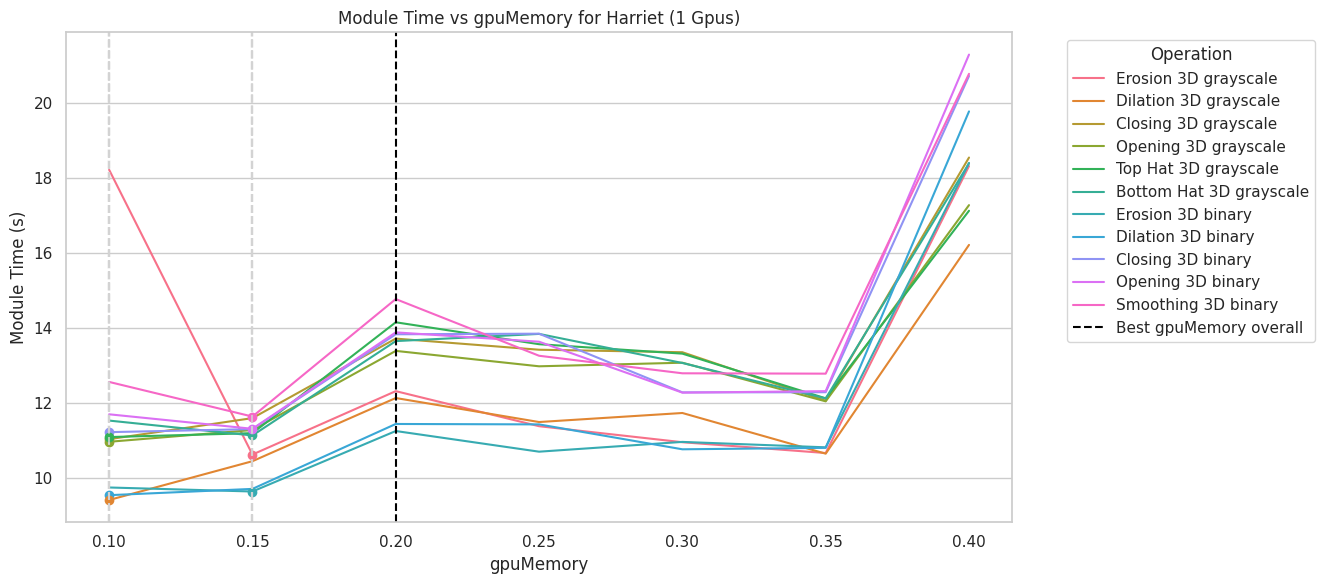

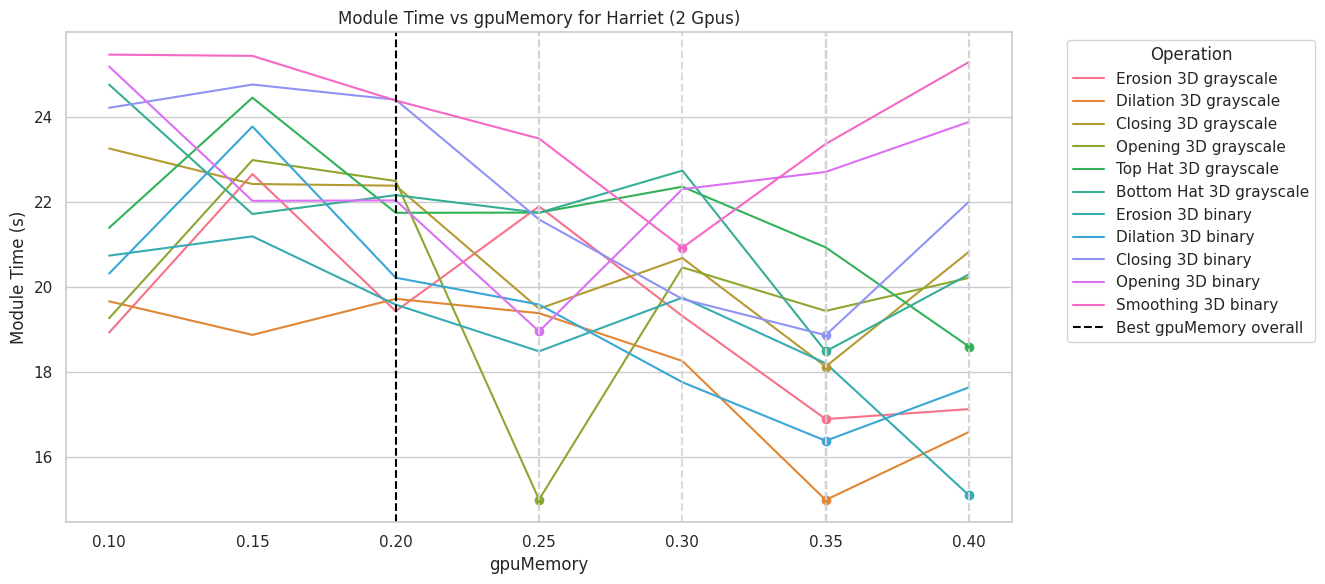

In [121]:
# Dictionary of gpu count to new line position
if(repetitions == 10): 
    new_lines = {1: 0.15, 2: 0.35}
elif(repetitions ==20):
    new_lines = {1: 0.15, 2: 0.35}

all_gpus = sorted(new_lines.keys())

# Set style for horizontal grid only
sns.set_style("whitegrid")
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["axes.grid.which"] = "major"

for ngpus in all_gpus:
    df_filtered_1 = df_cython2[df_cython2["Gpus"] == ngpus]
    df_filtered = df_filtered_1[df_filtered_1["Machine"] == "harriet"]
    
    if df_filtered.empty:
        continue  # Skip if no data
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    lineplot = sns.lineplot(
        data=df_filtered,
        x="gpuMemory",
        y="Module Time (s)",
        hue="Operation",
        ax=ax
    )
    
    # Get line colors by operation
    line_colors = {line.get_label(): line.get_color() for line in ax.get_lines()}
    
    # Plot dots and vertical dashed lines for min points
    for operation, group in df_filtered.groupby("Operation"):
        group_sorted = group.sort_values("gpuMemory")
        min_row = group_sorted.loc[group_sorted["Module Time (s)"].idxmin()]
        x_val = min_row["gpuMemory"]
        y_val = min_row["Module Time (s)"]
        color = line_colors[operation]
        ax.plot(x_val, y_val, "o", color=color)
        ax.axvline(x=x_val, linestyle="--", color="lightgray", alpha=0.8)

    # Determine monotonic decreasing cutoff
    valid_gpu_mems = sorted(df_filtered["gpuMemory"].unique())
    decreasing_cutoff = None
    for i in range(len(valid_gpu_mems)):
        current_cutoff = valid_gpu_mems[i]
        is_decreasing = True
        for operation, group in df_filtered.groupby("Operation"):
            sub = group.sort_values("gpuMemory")
            sub = sub[sub["gpuMemory"] <= current_cutoff]
            if not all(np.diff(sub["Module Time (s)"]) < 0):
                is_decreasing = False
                break
        if is_decreasing:
            decreasing_cutoff = current_cutoff

    # Add the specific black vertical line for this GPU count
    ax.axvline(
        x=new_lines[ngpus],
        linestyle="--",
        color="black",
        label="Best gpuMemory overall"
    )

    # Title and labels
    ax.set_title(f"Module Time vs gpuMemory for Harriet ({ngpus} Gpus)")
    ax.set_xlabel("gpuMemory")
    ax.set_ylabel("Module Time (s)")
    ax.set_xticks(valid_gpu_mems)

    # Custom legend
    handles, labels = ax.get_legend_handles_labels()
    unique_ops = df_filtered["Operation"].unique().tolist()
    new_handles_labels = [
        (h, l) for h, l in zip(handles, labels)
        if l in unique_ops or l in {"Best gpuMemory overall"}
    ]
    if new_handles_labels:
        handles, labels = zip(*new_handles_labels)
        ax.legend(handles, labels, title="Operation", loc='upper left', bbox_to_anchor=(1.05, 1))

    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    if(save): plt.savefig(f"{output_dir}/harriet_{ngpus}gpus_gpuMemory.png", dpi=300, bbox_inches='tight')
    plt.show()


In [127]:
# Filter the data
ngpus = 2
df_gpus = df_cython2[df_cython2["Gpus"] == ngpus]
df_filtered = df_gpus[df_gpus["Machine"] == "harriet"]

# Set the monotonic threshold value
threshold_gpu_mem = 0.35

# Prepare list to collect data
summary_data = []

# Process each operation
for operation, group in df_filtered.groupby("Operation"):
    group_sorted = group.sort_values("gpuMemory")

    # Get the min Module Time and corresponding gpuMemory
    min_row = group_sorted.loc[group_sorted["Module Time (s)"].idxmin()]
    min_time = min_row["Module Time (s)"]
    min_mem = min_row["gpuMemory"]

    # Get the Module Time at the threshold 
    thresh_row = group_sorted[group_sorted["gpuMemory"] == threshold_gpu_mem]
    if thresh_row.empty:
        continue  # Skip if the threshold is not available
    thresh_time = thresh_row["Module Time (s)"].values[0]

    # Compute absolute and relative differences
    abs_diff_us = (thresh_time - min_time) * 1e3  # Convert to miliseconds
    perc_faster = 100 * (1 - min_time / thresh_time)

    # Append to list
    summary_data.append({
        "Operation": operation,
        "Min Time (s)": min_time,
        "Min gpuMemory": min_mem,
        f"Time - {threshold_gpu_mem} gpuMemory (s)": thresh_time,
        "Saved Time (ms)": abs_diff_us,
        "Faster (%)": perc_faster
    })

# Create DataFrame
summary_df = pd.DataFrame(summary_data)

# Round for display
summary_df["Saved Time (ms)"] = summary_df["Saved Time (ms)"].round(2)
summary_df["Faster (%)"] = summary_df["Faster (%)"].round(2)

# Display the table
summary_df = summary_df.sort_values("Faster (%)", ascending=False)

save_df_as_image(summary_df, output_dir+f"/faster_table_{ngpus}gpus_{threshold_gpu_mem}.png", 300, False)

display(summary_df)
summary_df['Saved Time (ms)'].sum() #tempo 'perdido' por não usar o melhor gpu_memory

benchmark_read/Cuda_20reps_plots/faster_table_2gpus_0.35.png


Operation  Min Time (s)  Min gpuMemory  \
8      Opening 3D grayscale     15.005450           0.25   
5         Erosion 3D binary     15.105242           0.40   
7         Opening 3D binary     18.963158           0.25   
10     Top Hat 3D grayscale     18.603099           0.40   
9       Smoothing 3D binary     20.931452           0.30   
0   Bottom Hat 3D grayscale     18.492223           0.35   
1         Closing 3D binary     18.872793           0.35   
2      Closing 3D grayscale     18.135330           0.35   
3        Dilation 3D binary     16.388936           0.35   
4     Dilation 3D grayscale     14.995924           0.35   
6      Erosion 3D grayscale     16.898950           0.35   

    Time - 0.35 gpuMemory (s)  Saved Time (ms)  Faster (%)  
8                   19.443871          4438.42       22.83  
5                   18.213717          3108.48       17.07  
7                   22.714224          3751.07       16.51  
10                  20.939891          2336.79       11.16  
9                   23.373887          2442.43       10.45  
0                   18.492223             0.00        0.00  
1                   18.872793             0.00        0.00  
2                   18.135330             0.00        0.00  
3                   16.388936             0.00        0.00  
4                   14.995924             0.00        0.00  
6                   16.898950             0.00        0.00

16077.19

## Cuda test

In [32]:
repetitions = 20 #número de repetições executadas no teste
save = True #wheter to save the plots as figures
notebook_name = f"benchmark_read/Cuda_{repetitions}reps"
output_dir = f"{notebook_name}_plots"
os.makedirs(output_dir, exist_ok=True)
print(f"Plots will be saved to: {output_dir}")

Plots will be saved to: benchmark_read/Cuda_20reps_plots


### Read data

In [33]:
df_cuda['Machine'].unique()

array(['harriet', 'notebook'], dtype=object)

In [34]:
current_dir = os.getcwd()
cuda_results_dir = os.path.join(current_dir, "results_cuda")
df_cuda = read_csv_files(cuda_results_dir)
if(repetitions): df_cuda = filter_dataframe(df_cuda, {'Repetitions': repetitions}) #eliminate 'read_input' timing
df_cuda

Searching in: /ibira/lnls/labs/tepui/home/camila.araujo/work/harpia/tests_python/benchmark/results_cuda
Loaded 10 CSV files.


Operation  Machine  Gpus  gpuMemory  Module Time (s)  \
239                erosion_binary  harriet     2        0.1         11306026   
240               dilation_binary  harriet     2        0.1          8964166   
241                closing_binary  harriet     2        0.1          9902074   
242                opening_binary  harriet     2        0.1          9976260   
243                 smooth_binary  harriet     2        0.1         11288935   
...                           ...      ...   ...        ...              ...   
1597            opening_grayscale  harriet     3        0.4          8374596   
1598   geodesic_erosion_grayscale  harriet     3        0.4         11857777   
1599  geodesic_dilation_grayscale  harriet     3        0.4         11935538   
1600                      top_hat  harriet     3        0.4          8533452   
1601                   bottom_hat  harriet     3        0.4          8424239   

      Repetitions Image Data Type  xsize  ysize  zsize  
239            20           int32   2052   2052   2048  
240            20           int32   2052   2052   2048  
241            20           int32   2052   2052   2048  
242            20           int32   2052   2052   2048  
243            20           int32   2052   2052   2048  
...           ...             ...    ...    ...    ...  
1597           20           int32   2052   2052   2048  
1598           20           int32   2052   2052   2048  
1599           20           int32   2052   2052   2048  
1600           20           int32   2052   2052   2048  
1601           20           int32   2052   2052   2048  

[705 rows x 10 columns]

### Complete df information

In [35]:
#Correct time unit
df_cuda["Module Time (s)"] = df_cuda.apply(lambda row: row["Module Time (s)"]/(10e5), axis=1)

dtype_bytes = {
    'int16': 2, 'uint16': 2,
    'int32': 4, 'uint32': 4,
    'int64': 8, 'uint64': 8,
    'float32': 4
}

# Add the "Image Dimensions" column
df_cuda["Image Dimensions"] = df_cuda.apply(lambda row: f"({row['xsize']}, {row['ysize']}, {row['zsize']})", axis=1)

# Function to compute the image size in MB
def compute_image_size(row):
    shape = row['xsize'] * row['ysize'] * row['zsize']
    dtype_str = row['Image Data Type']
    bytes_per_pixel = dtype_bytes.get(dtype_str, 0)  # 0 if unknown type
    size_in_mb = shape * bytes_per_pixel / (1024 ** 2)
    return round(size_in_mb, 1)

# Add the "Image Size (MB)" column
df_cuda["Image Size (MB)"] = df_cuda.apply(compute_image_size, axis=1)

df_cuda = df_cuda[df_cuda['Operation'] != 'read_input']

In [36]:
#workaround to plot only for 20 repetitions ina new directory
df_cuda_notebook = df_cuda[df_cuda['Machine']=='notebook']
df_cuda

Operation  Machine  Gpus  gpuMemory  Module Time (s)  \
239                erosion_binary  harriet     2        0.1        11.306026   
240               dilation_binary  harriet     2        0.1         8.964166   
241                closing_binary  harriet     2        0.1         9.902074   
242                opening_binary  harriet     2        0.1         9.976260   
243                 smooth_binary  harriet     2        0.1        11.288935   
...                           ...      ...   ...        ...              ...   
1597            opening_grayscale  harriet     3        0.4         8.374596   
1598   geodesic_erosion_grayscale  harriet     3        0.4        11.857777   
1599  geodesic_dilation_grayscale  harriet     3        0.4        11.935538   
1600                      top_hat  harriet     3        0.4         8.533452   
1601                   bottom_hat  harriet     3        0.4         8.424239   

      Repetitions Image Data Type  xsize  ysize  zsize    Image Dimensions  \
239            20           int32   2052   2052   2048  (2052, 2052, 2048)   
240            20           int32   2052   2052   2048  (2052, 2052, 2048)   
241            20           int32   2052   2052   2048  (2052, 2052, 2048)   
242            20           int32   2052   2052   2048  (2052, 2052, 2048)   
243            20           int32   2052   2052   2048  (2052, 2052, 2048)   
...           ...             ...    ...    ...    ...                 ...   
1597           20           int32   2052   2052   2048  (2052, 2052, 2048)   
1598           20           int32   2052   2052   2048  (2052, 2052, 2048)   
1599           20           int32   2052   2052   2048  (2052, 2052, 2048)   
1600           20           int32   2052   2052   2048  (2052, 2052, 2048)   
1601           20           int32   2052   2052   2048  (2052, 2052, 2048)   

      Image Size (MB)  
239           32896.1  
240           32896.1  
241           32896.1  
242           32896.1  
243           32896.1  
...               ...  
1597          32896.1  
1598          32896.1  
1599          32896.1  
1600          32896.1  
1601          32896.1  

[705 rows x 12 columns]

### Plots Harriet

#### Time vs Number of Gpus

/ibira/lnls/labs/tepui/home/camila.araujo/work/envs/jupyter/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/ibira/lnls/labs/tepui/home/camila.araujo/work/envs/jupyter/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/ibira/lnls/labs/tepui/home/camila.araujo/work/envs/jupyter/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/ibira/lnls/labs/tepui/home/camila.araujo/work/envs/jupyter/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/ibira/lnls/labs/tepui/home/camila.arauj

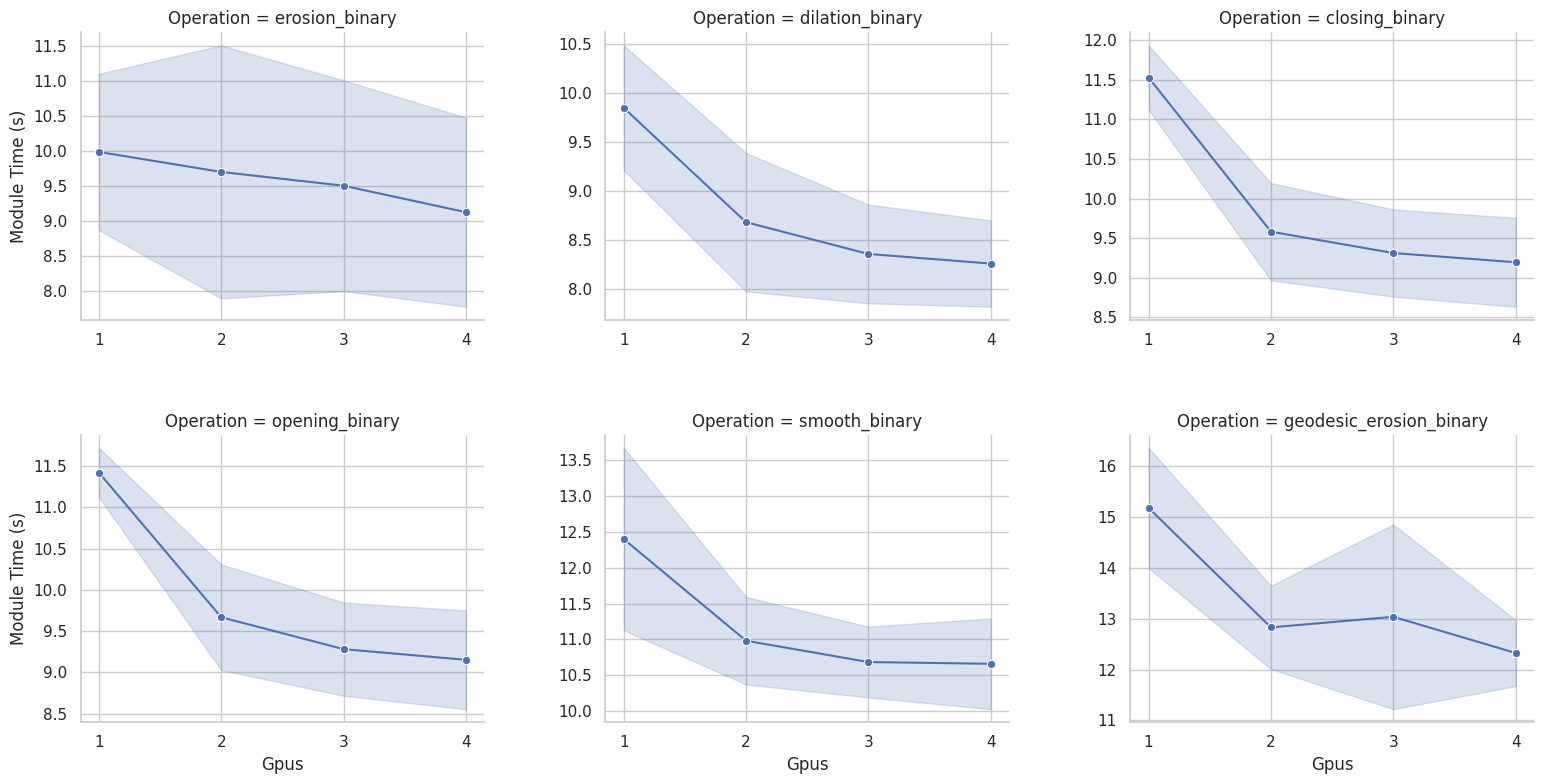

/ibira/lnls/labs/tepui/home/camila.araujo/work/envs/jupyter/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/ibira/lnls/labs/tepui/home/camila.araujo/work/envs/jupyter/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/ibira/lnls/labs/tepui/home/camila.araujo/work/envs/jupyter/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/ibira/lnls/labs/tepui/home/camila.araujo/work/envs/jupyter/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/ibira/lnls/labs/tepui/home/camila.arauj

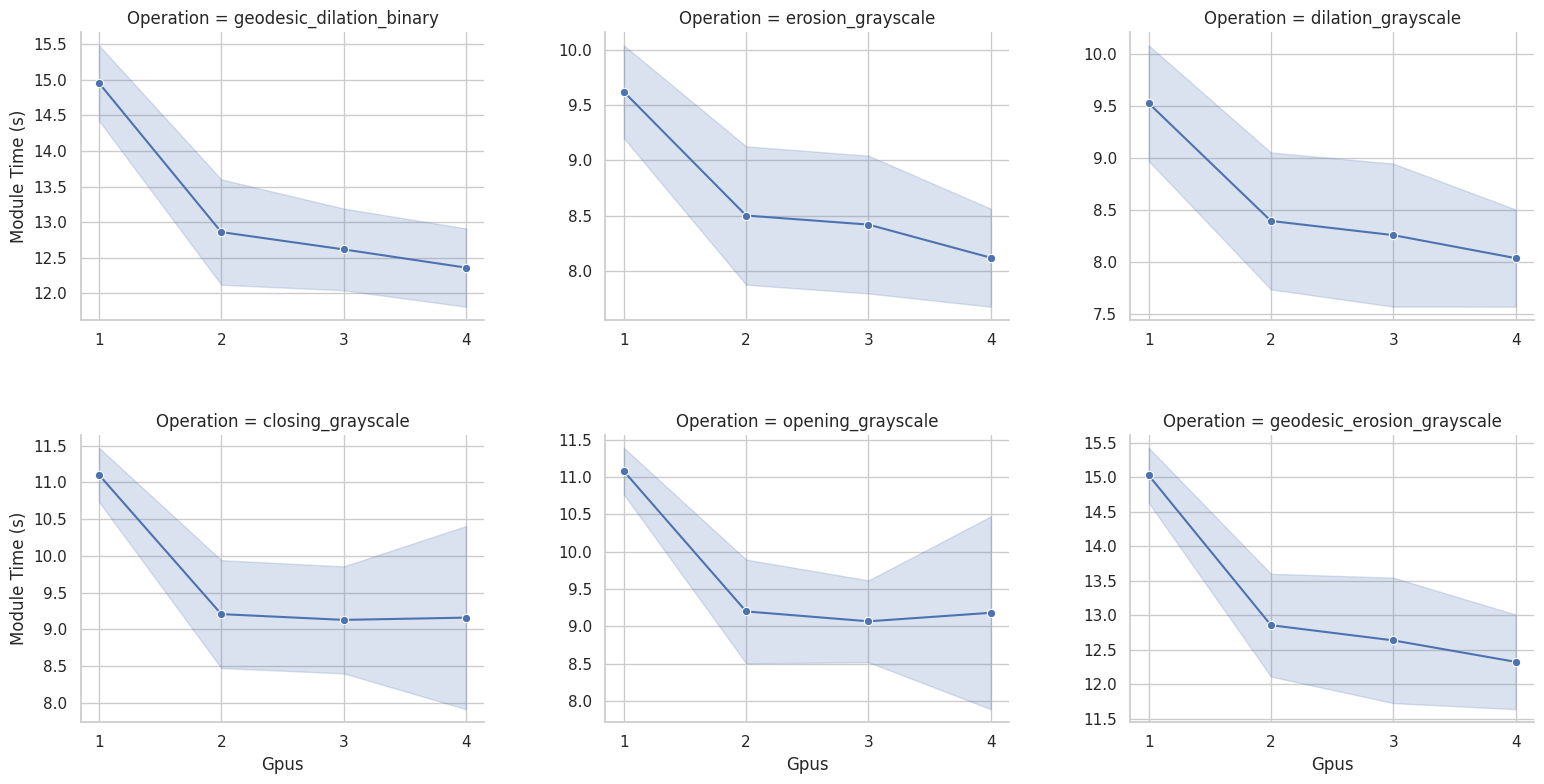

/ibira/lnls/labs/tepui/home/camila.araujo/work/envs/jupyter/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/ibira/lnls/labs/tepui/home/camila.araujo/work/envs/jupyter/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/ibira/lnls/labs/tepui/home/camila.araujo/work/envs/jupyter/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)


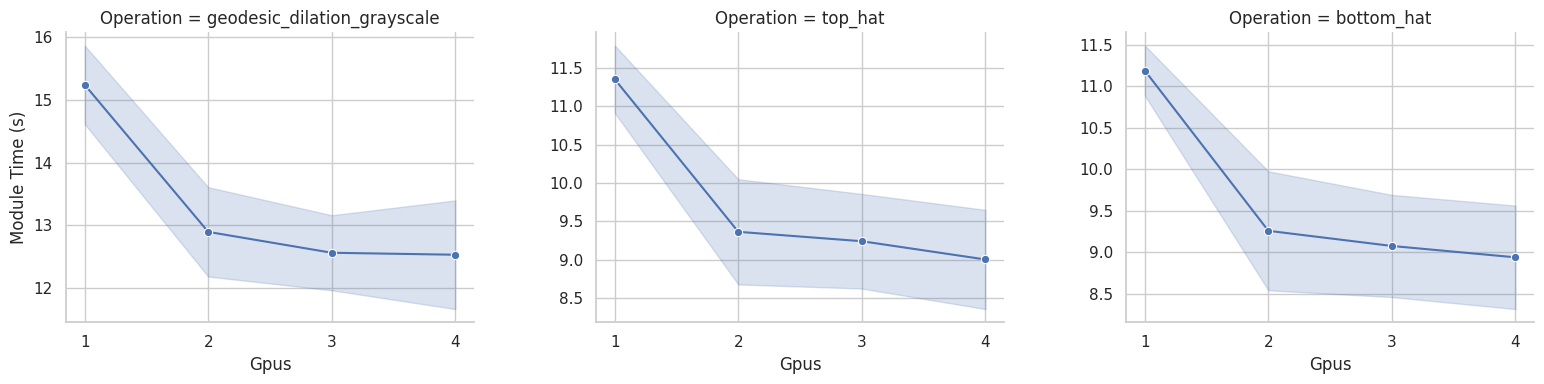

In [37]:
# Filter the dataset
df_filtered = df_cuda[df_cuda["Machine"] == "harriet"]

# Get unique Operations and Gpus
unique_ops = df_filtered["Operation"].unique()
unique_gpus = sorted(df_filtered["Gpus"].unique())

# Group Operations in chunks of 6
ops_per_plot = 6
n_chunks = int(np.ceil(len(unique_ops) / ops_per_plot))

sns.set(style="whitegrid")

for i in range(n_chunks):
    ops_chunk = unique_ops[i * ops_per_plot:(i + 1) * ops_per_plot]
    chunk_df = df_filtered[df_filtered["Operation"].isin(ops_chunk)]

    g = sns.relplot(
        data=chunk_df,
        x="Gpus",
        y="Module Time (s)",
        col="Operation",
        col_wrap=3,  # Always 3 columns
        kind="line",
        ci="sd",
        marker="o",
        facet_kws={'sharey': False, 'sharex': True},
        height=4,
        aspect=1.3
    )

    # Force xticks and labels to appear in every subplot
    for ax in g.axes.flat:
        ax.set_xticks(unique_gpus)
        ax.tick_params(axis='x', labelbottom=True)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.show()

/tmp/ipykernel_24602/543199289.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.lineplot(


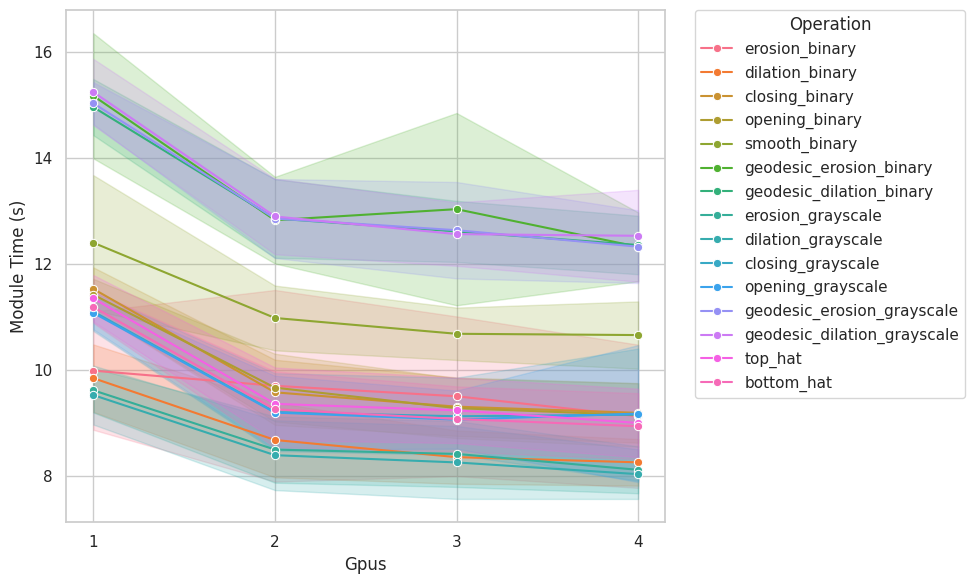

In [38]:
# Filter data
df_filtered = df_cuda[df_cuda["Machine"] == "harriet"]

# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=df_filtered,
    x="Gpus",
    y="Module Time (s)",
    hue="Operation",
    ci="sd",
    marker="o"
)

# Move legend outside
ax.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.,
    title="Operation"
)

# Set xticks to the unique Gpus
ax.set_xticks(sorted(df_filtered["Gpus"].unique()))

plt.tight_layout()
plt.show()

#### Time vs Number of Gpus (Trends)

In [39]:
df_cuda

Operation  Machine  Gpus  gpuMemory  Module Time (s)  \
239                erosion_binary  harriet     2        0.1        11.306026   
240               dilation_binary  harriet     2        0.1         8.964166   
241                closing_binary  harriet     2        0.1         9.902074   
242                opening_binary  harriet     2        0.1         9.976260   
243                 smooth_binary  harriet     2        0.1        11.288935   
...                           ...      ...   ...        ...              ...   
1597            opening_grayscale  harriet     3        0.4         8.374596   
1598   geodesic_erosion_grayscale  harriet     3        0.4        11.857777   
1599  geodesic_dilation_grayscale  harriet     3        0.4        11.935538   
1600                      top_hat  harriet     3        0.4         8.533452   
1601                   bottom_hat  harriet     3        0.4         8.424239   

      Repetitions Image Data Type  xsize  ysize  zsize    Image Dimensions  \
239            20           int32   2052   2052   2048  (2052, 2052, 2048)   
240            20           int32   2052   2052   2048  (2052, 2052, 2048)   
241            20           int32   2052   2052   2048  (2052, 2052, 2048)   
242            20           int32   2052   2052   2048  (2052, 2052, 2048)   
243            20           int32   2052   2052   2048  (2052, 2052, 2048)   
...           ...             ...    ...    ...    ...                 ...   
1597           20           int32   2052   2052   2048  (2052, 2052, 2048)   
1598           20           int32   2052   2052   2048  (2052, 2052, 2048)   
1599           20           int32   2052   2052   2048  (2052, 2052, 2048)   
1600           20           int32   2052   2052   2048  (2052, 2052, 2048)   
1601           20           int32   2052   2052   2048  (2052, 2052, 2048)   

      Image Size (MB)  
239           32896.1  
240           32896.1  
241           32896.1  
242           32896.1  
243           32896.1  
...               ...  
1597          32896.1  
1598          32896.1  
1599          32896.1  
1600          32896.1  
1601          32896.1  

[705 rows x 12 columns]

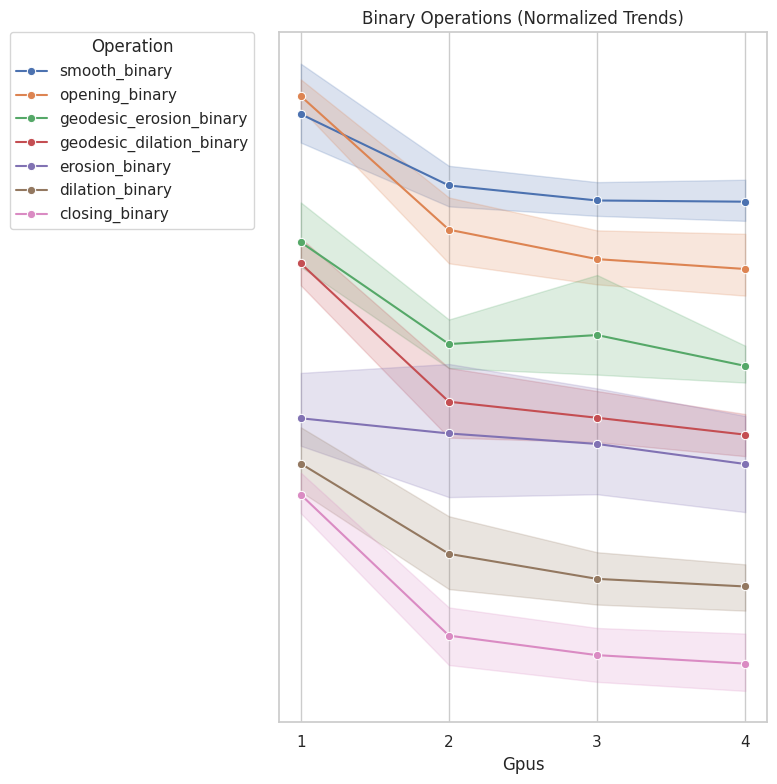

In [40]:
# Binary operation list
binary_ops = [
    'erosion_binary', 'dilation_binary', 'closing_binary',
    'opening_binary', 'smooth_binary', 'geodesic_erosion_binary',
    'geodesic_dilation_binary'
]
binary_ops.sort(reverse=True)

# Filter and prepare data
df_binary = df_cuda[(df_cuda["Machine"] == "harriet") & (df_cuda["Operation"].isin(binary_ops))].copy()

# Normalize and offset
offset_step = 0.3
operation_offsets = {op: i * offset_step for i, op in enumerate(sorted(df_binary["Operation"].unique()))}

df_normalized = []
for op, group in df_binary.groupby("Operation"):
    offset = operation_offsets[op]
    norm_time = (group["Module Time (s)"] - group["Module Time (s)"].min()) / (
        group["Module Time (s)"].max() - group["Module Time (s)"].min()
    )
    group = group.copy()
    group["Offset Time"] = norm_time + offset
    df_normalized.append(group)

df_plot_binary = pd.concat(df_normalized)

# Plot
plt.figure(figsize=(8, 8))
ax = sns.lineplot(
    data=df_plot_binary,
    x="Gpus",
    y="Offset Time",
    hue="Operation",
    hue_order = binary_ops,
    marker="o"
)
ax.legend(bbox_to_anchor=(-0.05, 1), loc='upper right', borderaxespad=0., title="Operation")
ax.set_xticks(sorted(df_binary["Gpus"].unique()))
ax.set_yticks([])
ax.set_ylabel("")
plt.title("Binary Operations (Normalized Trends)")
plt.tight_layout()
plt.show()

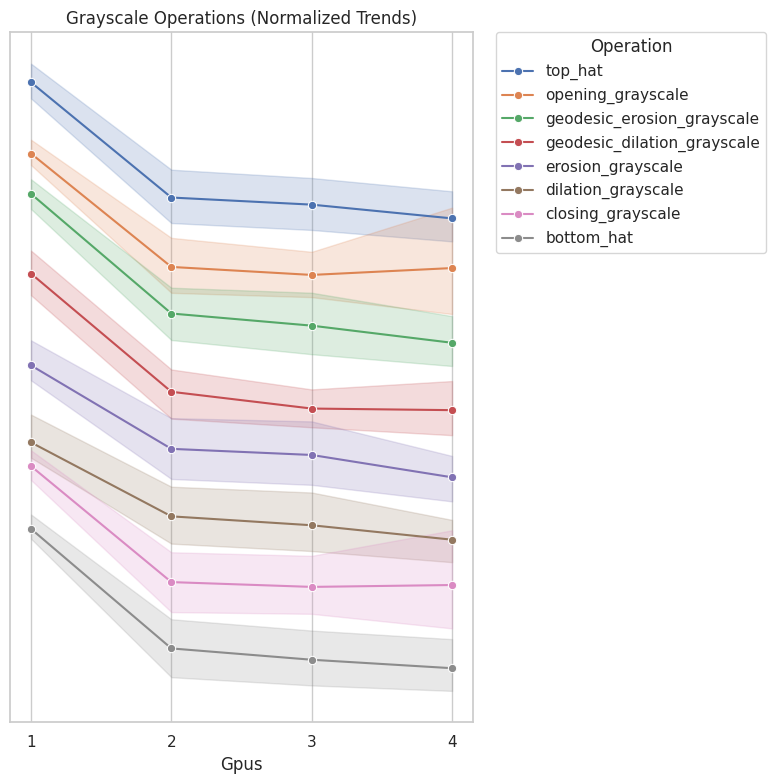

In [41]:
# Grayscale operation list
grayscale_ops = [
    'erosion_grayscale', 'dilation_grayscale', 'closing_grayscale',
    'opening_grayscale', 'geodesic_erosion_grayscale', 'geodesic_dilation_grayscale',
    'top_hat', 'bottom_hat'
]
grayscale_ops.sort(reverse=True)
# Filter and prepare data
df_grayscale = df_cuda[(df_cuda["Machine"] == "harriet") & (df_cuda["Operation"].isin(grayscale_ops))].copy()

# Normalize and offset
operation_offsets = {op: i * offset_step for i, op in enumerate(sorted(df_grayscale["Operation"].unique()))}

df_normalized = []
for op, group in df_grayscale.groupby("Operation"):
    offset = operation_offsets[op]
    norm_time = (group["Module Time (s)"] - group["Module Time (s)"].min()) / (
        group["Module Time (s)"].max() - group["Module Time (s)"].min()
    )
    group = group.copy()
    group["Offset Time"] = norm_time + offset
    df_normalized.append(group)

df_plot_grayscale = pd.concat(df_normalized)

# Plot
plt.figure(figsize=(8, 8))
ax = sns.lineplot(
    data=df_plot_grayscale,
    x="Gpus",
    y="Offset Time",
    hue="Operation",
    hue_order = grayscale_ops,
    marker="o"
)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="Operation")
ax.set_xticks(sorted(df_grayscale["Gpus"].unique()))
ax.set_yticks([])
ax.set_ylabel("")
plt.title("Grayscale Operations (Normalized Trends)")
plt.tight_layout()
plt.show()


#### Time vs Numper of Gpus (for each gpuMemory individually)

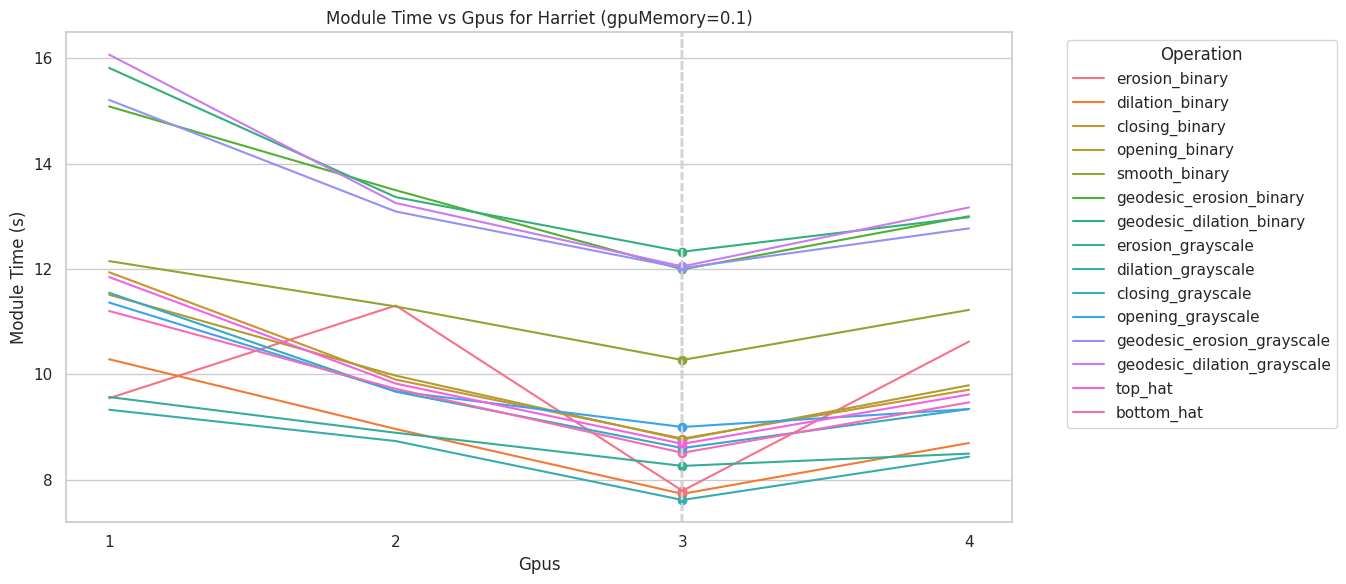

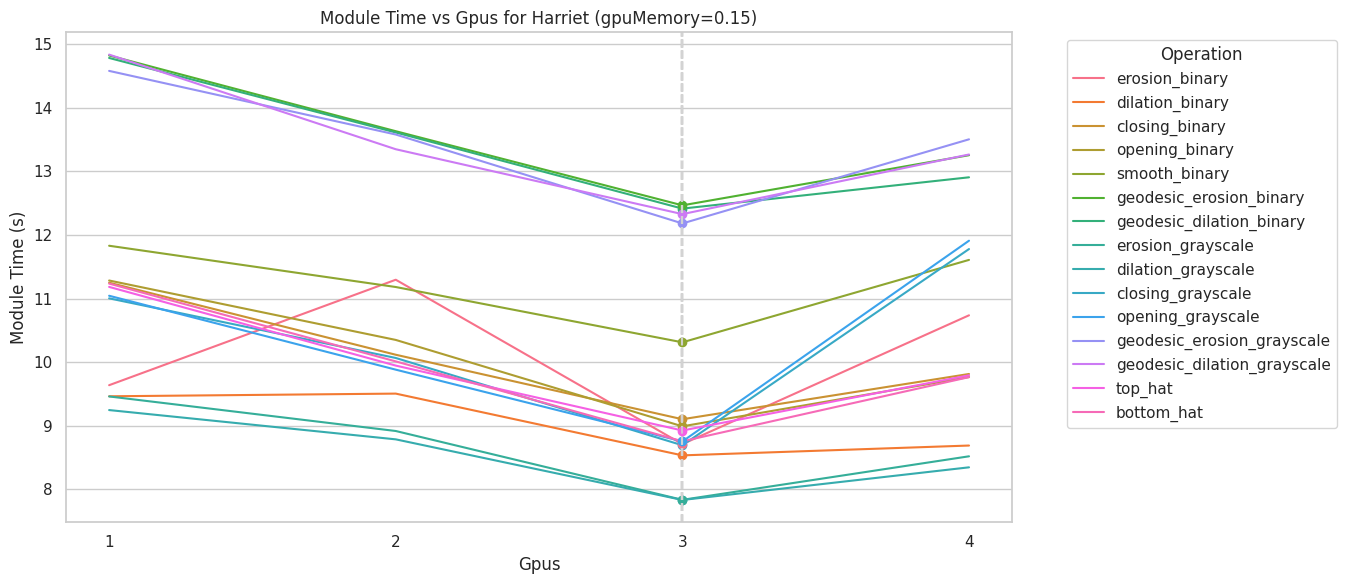

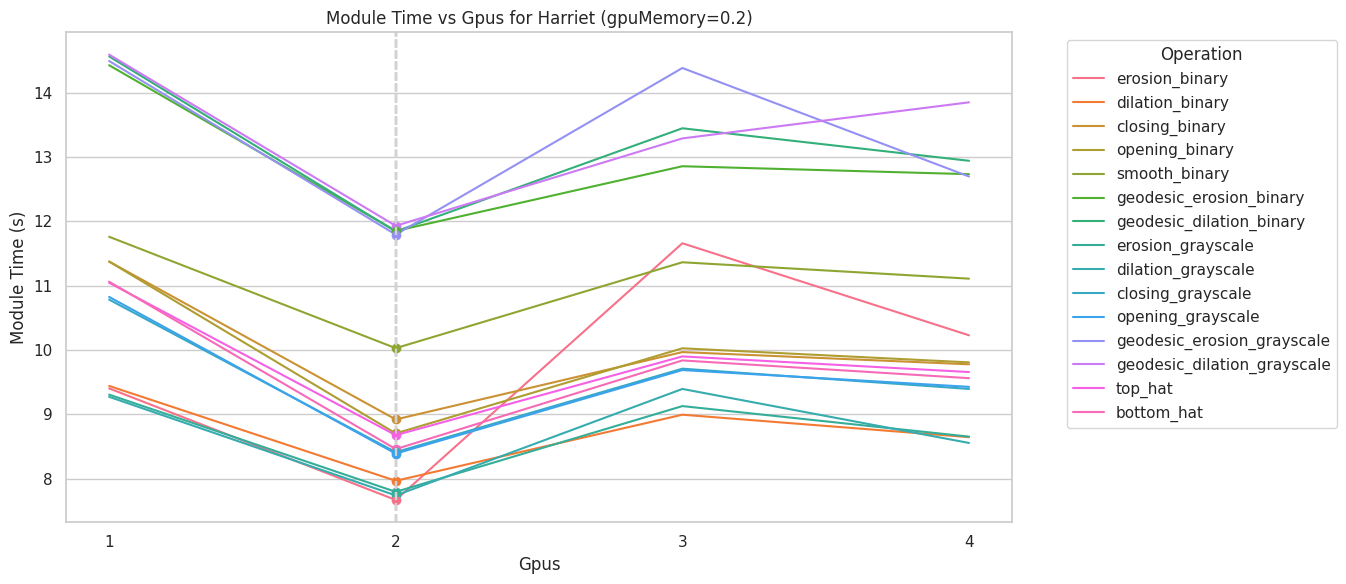

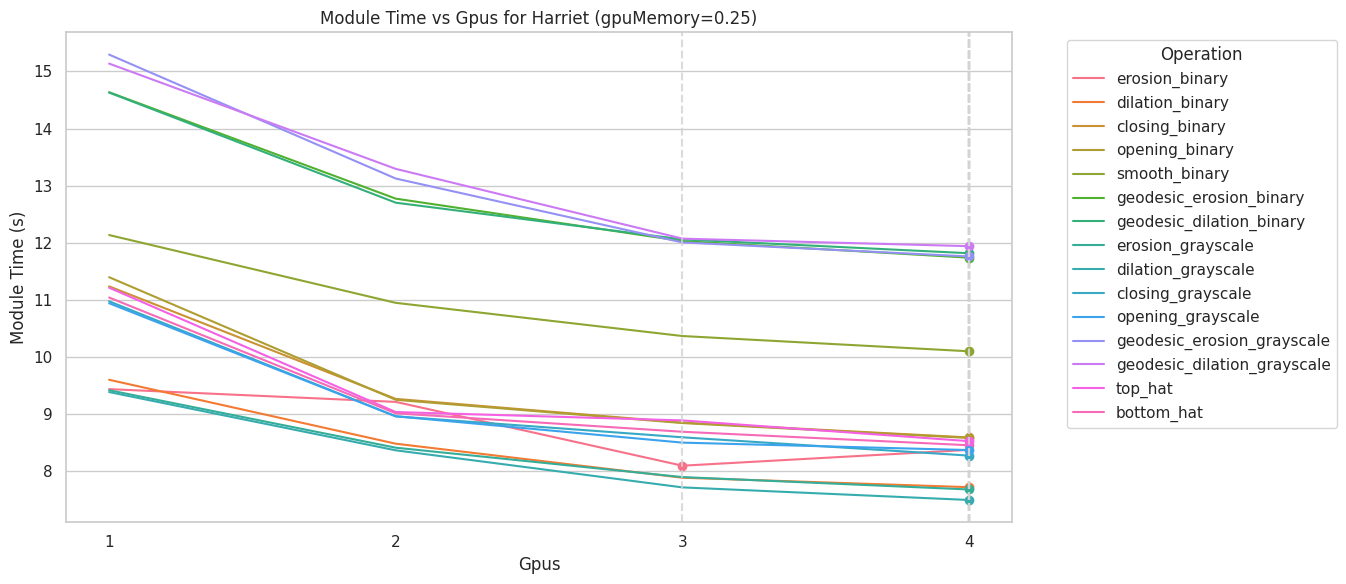

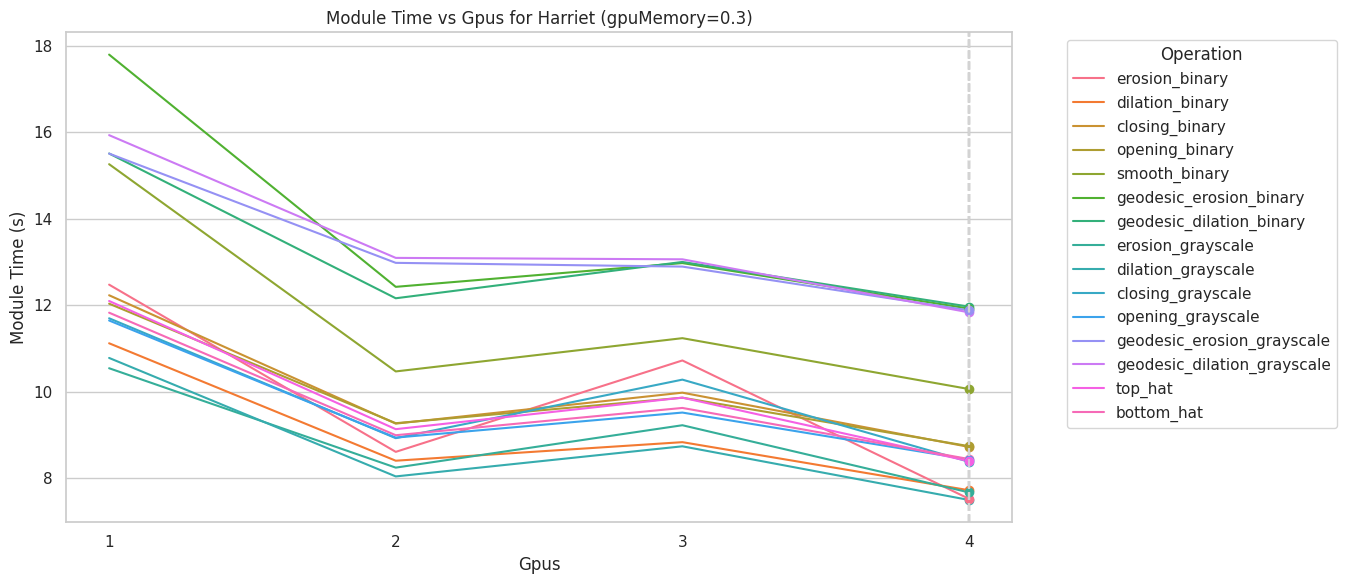

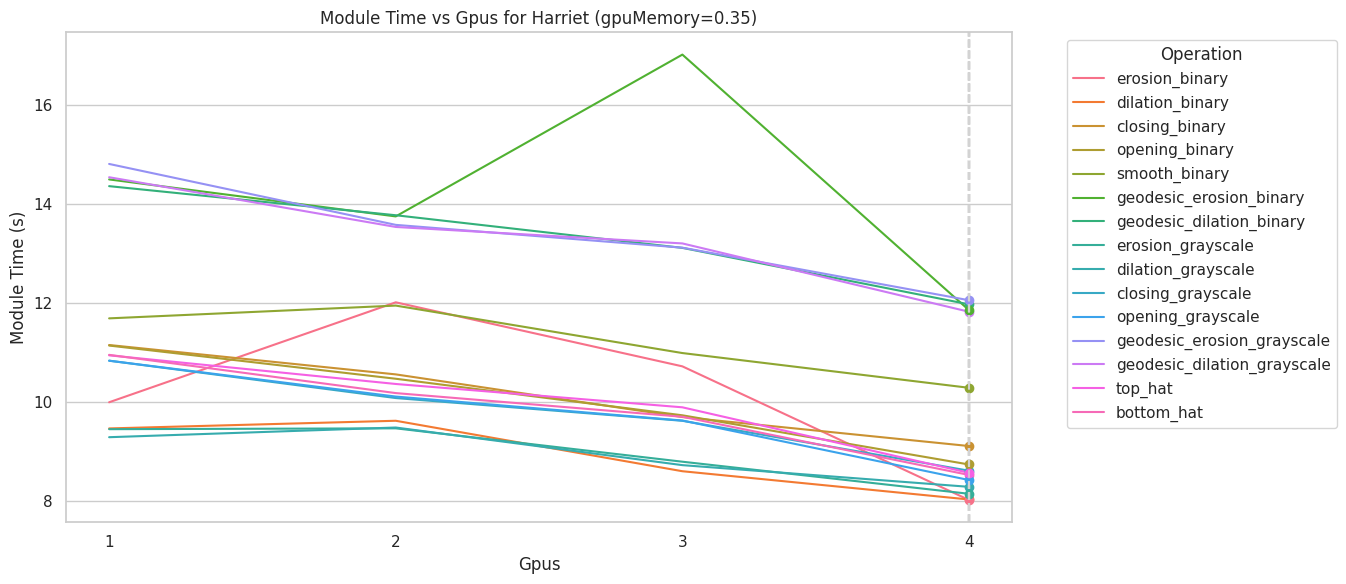

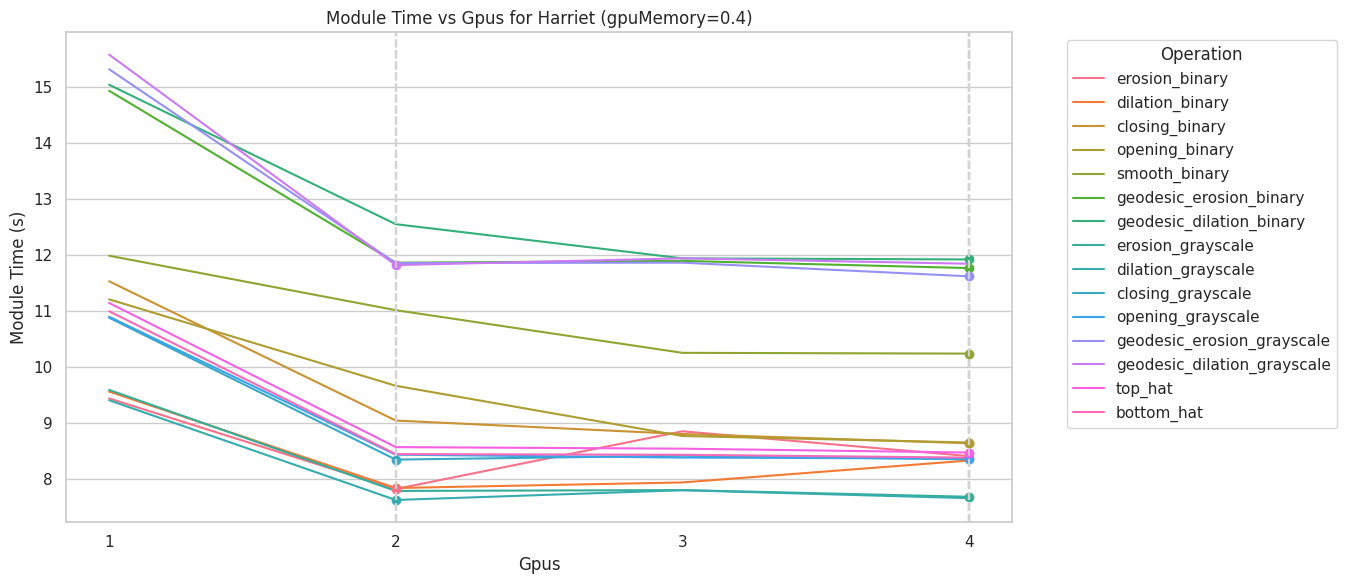

In [42]:
# Set style for horizontal grid only
sns.set_style("whitegrid")
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["axes.grid.which"] = "major"

all_gpu_mems = sorted(df_cuda["gpuMemory"].unique())

for gpu_mem in all_gpu_mems:
    df_filtered_1 = df_cuda[df_cuda["gpuMemory"] == gpu_mem]
    df_filtered = df_filtered_1[df_filtered_1["Machine"] == "harriet"]
    
    if df_filtered.empty:
        continue  # Skip if no data

    fig, ax = plt.subplots(figsize=(12, 6))
    
    lineplot = sns.lineplot(
        data=df_filtered,
        x="Gpus",
        y="Module Time (s)",
        hue="Operation",
        ax=ax
    )
    
    # Get line colors by operation
    line_colors = {line.get_label(): line.get_color() for line in ax.get_lines()}

    # Plot dots and vertical dashed lines for min points
    for operation, group in df_filtered.groupby("Operation"):
        group_sorted = group.sort_values("Gpus")
        min_row = group_sorted.loc[group_sorted["Module Time (s)"].idxmin()]
        x_val = min_row["Gpus"]
        y_val = min_row["Module Time (s)"]
        color = line_colors[operation]
        ax.plot(x_val, y_val, "o", color=color)
        ax.axvline(x=x_val, linestyle="--", color="lightgray", alpha=0.8)

    # Title and labels
    ax.set_title(f"Module Time vs Gpus for Harriet (gpuMemory={gpu_mem})")
    ax.set_xlabel("Gpus")
    ax.set_ylabel("Module Time (s)")
    ax.set_xticks(sorted(df_filtered["Gpus"].unique()))

    # Custom legend
    handles, labels = ax.get_legend_handles_labels()
    unique_ops = df_filtered["Operation"].unique().tolist()
    new_handles_labels = [
        (h, l) for h, l in zip(handles, labels)
        if l in unique_ops
    ]
    if new_handles_labels:
        handles, labels = zip(*new_handles_labels)
        ax.legend(handles, labels, title="Operation", loc='upper left', bbox_to_anchor=(1.05, 1))

    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    if(save): plt.savefig(f"{output_dir}/harriet_gpuMemory{gpu_mem}_gpus.png", dpi=300, bbox_inches='tight')
    plt.show()


#### Time vs gpuMemory (for each Numper of Gpus individually)

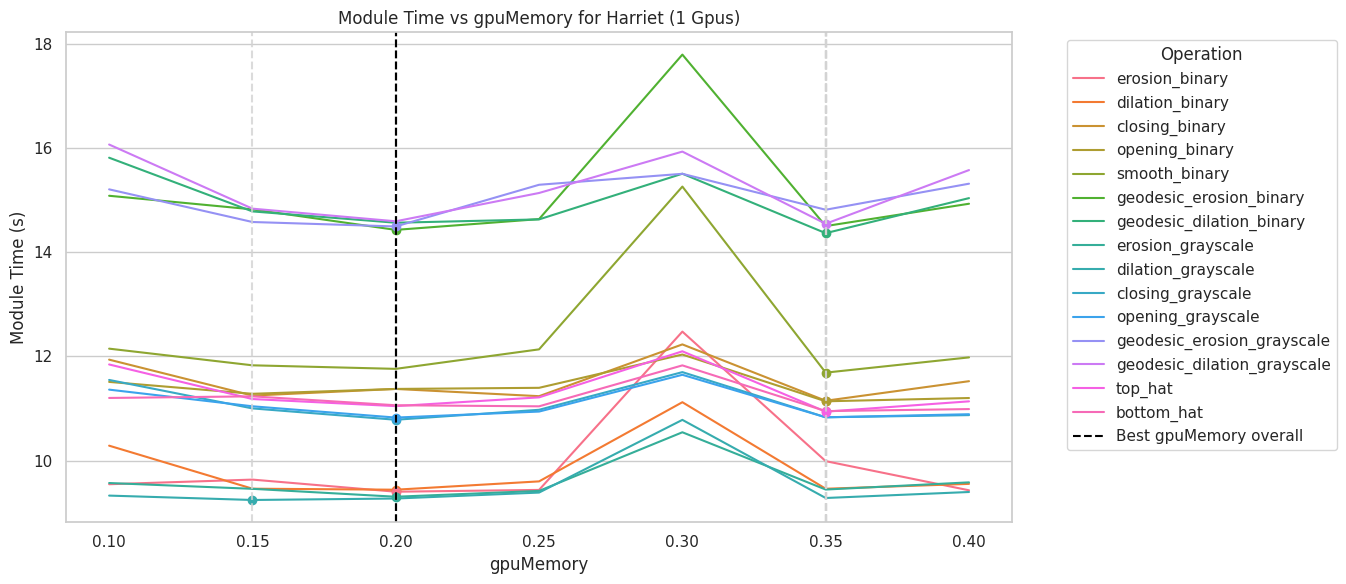

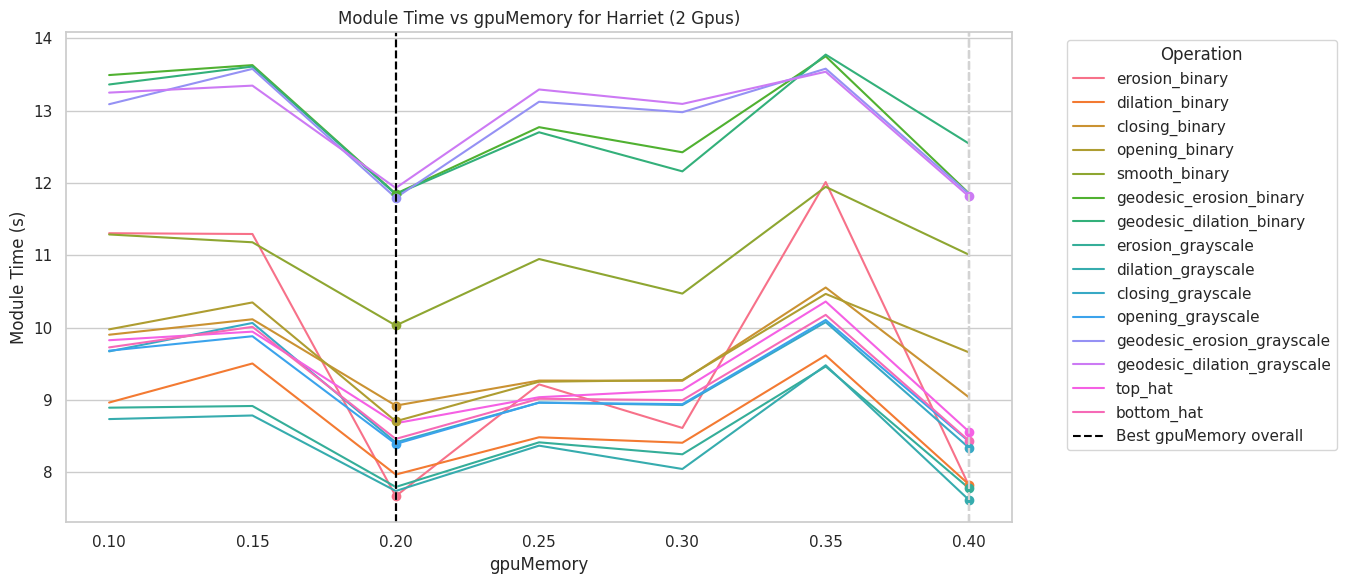

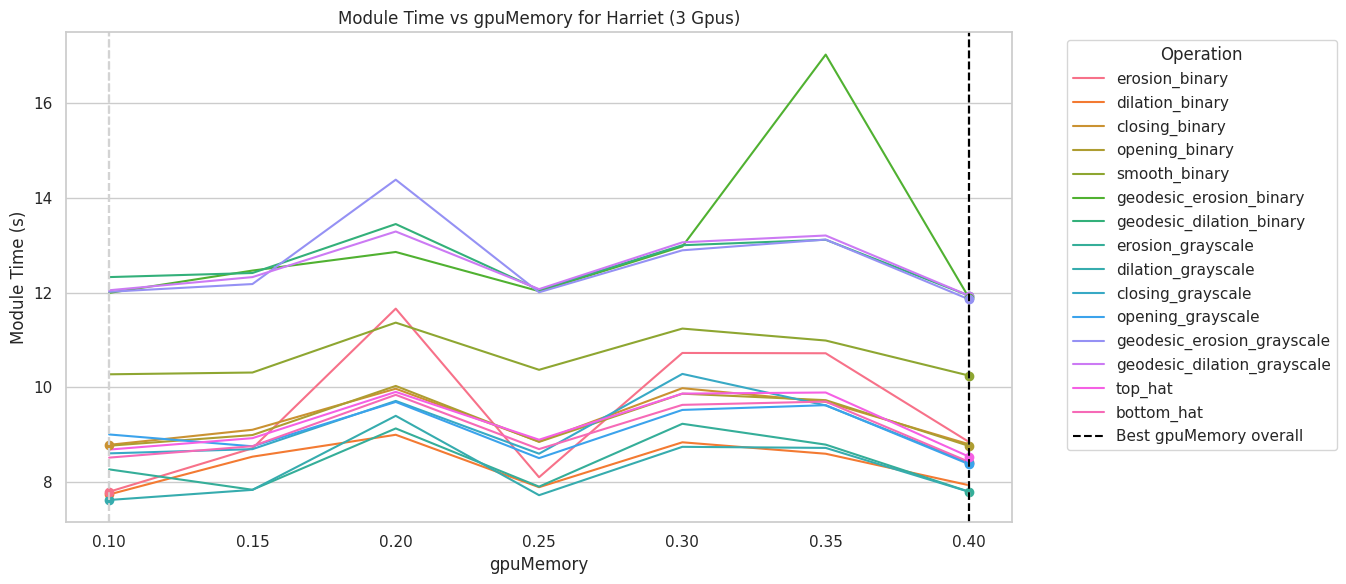

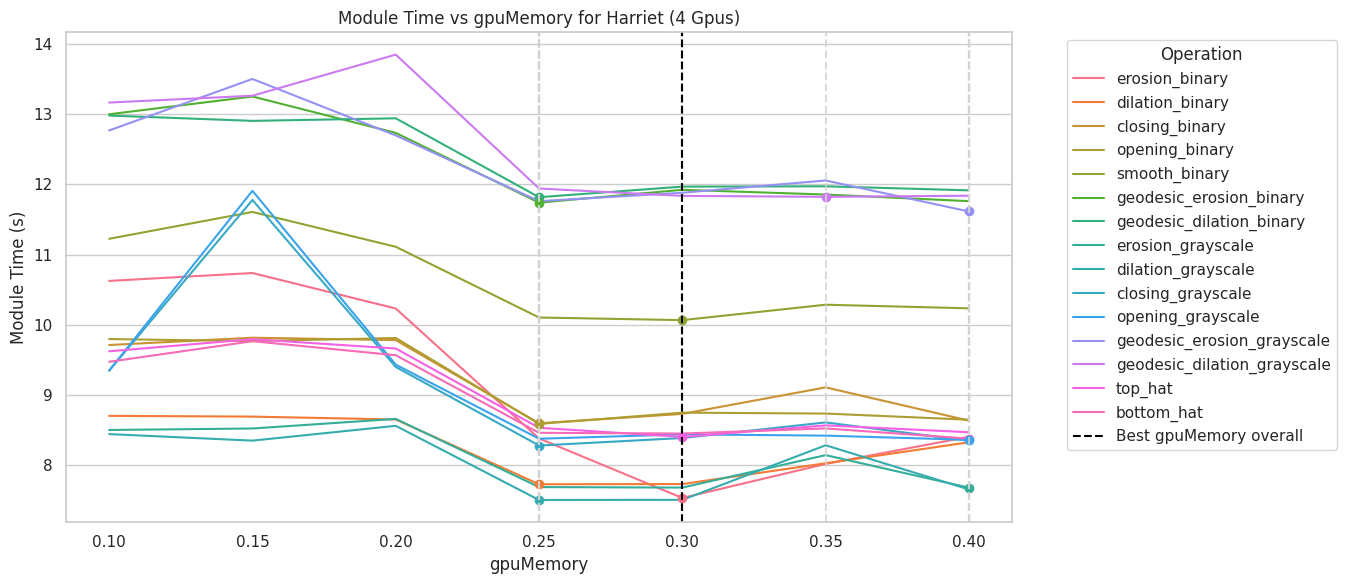

In [43]:
# Dictionary of gpu count to new line position
if(repetitions == 10): 
    new_lines = {1: 0.3, 2: 0.25, 3: 0.4, 4: 0.35}
elif(repetitions ==20):
    new_lines = {1: 0.2, 2: 0.2, 3: 0.4, 4: 0.3}

all_gpus = sorted(new_lines.keys())

# Set style for horizontal grid only
sns.set_style("whitegrid")
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["axes.grid.which"] = "major"

for ngpus in all_gpus:
    df_filtered_1 = df_cuda[df_cuda["Gpus"] == ngpus]
    df_filtered = df_filtered_1[df_filtered_1["Machine"] == "harriet"]
    
    if df_filtered.empty:
        continue  # Skip if no data
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    lineplot = sns.lineplot(
        data=df_filtered,
        x="gpuMemory",
        y="Module Time (s)",
        hue="Operation",
        ax=ax
    )
    
    # Get line colors by operation
    line_colors = {line.get_label(): line.get_color() for line in ax.get_lines()}
    
    # Plot dots and vertical dashed lines for min points
    for operation, group in df_filtered.groupby("Operation"):
        group_sorted = group.sort_values("gpuMemory")
        min_row = group_sorted.loc[group_sorted["Module Time (s)"].idxmin()]
        x_val = min_row["gpuMemory"]
        y_val = min_row["Module Time (s)"]
        color = line_colors[operation]
        ax.plot(x_val, y_val, "o", color=color)
        ax.axvline(x=x_val, linestyle="--", color="lightgray", alpha=0.8)

    # Determine monotonic decreasing cutoff
    valid_gpu_mems = sorted(df_filtered["gpuMemory"].unique())
    decreasing_cutoff = None
    for i in range(len(valid_gpu_mems)):
        current_cutoff = valid_gpu_mems[i]
        is_decreasing = True
        for operation, group in df_filtered.groupby("Operation"):
            sub = group.sort_values("gpuMemory")
            sub = sub[sub["gpuMemory"] <= current_cutoff]
            if not all(np.diff(sub["Module Time (s)"]) < 0):
                is_decreasing = False
                break
        if is_decreasing:
            decreasing_cutoff = current_cutoff

    # Add the specific black vertical line for this GPU count
    ax.axvline(
        x=new_lines[ngpus],
        linestyle="--",
        color="black",
        label="Best gpuMemory overall"
    )

    # Title and labels
    ax.set_title(f"Module Time vs gpuMemory for Harriet ({ngpus} Gpus)")
    ax.set_xlabel("gpuMemory")
    ax.set_ylabel("Module Time (s)")
    ax.set_xticks(valid_gpu_mems)

    # Custom legend
    handles, labels = ax.get_legend_handles_labels()
    unique_ops = df_filtered["Operation"].unique().tolist()
    new_handles_labels = [
        (h, l) for h, l in zip(handles, labels)
        if l in unique_ops or l in {"Best gpuMemory overall"}
    ]
    if new_handles_labels:
        handles, labels = zip(*new_handles_labels)
        ax.legend(handles, labels, title="Operation", loc='upper left', bbox_to_anchor=(1.05, 1))

    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    if(save): plt.savefig(f"{output_dir}/harriet_{ngpus}gpus_gpuMemory.png", dpi=300, bbox_inches='tight')
    plt.show()


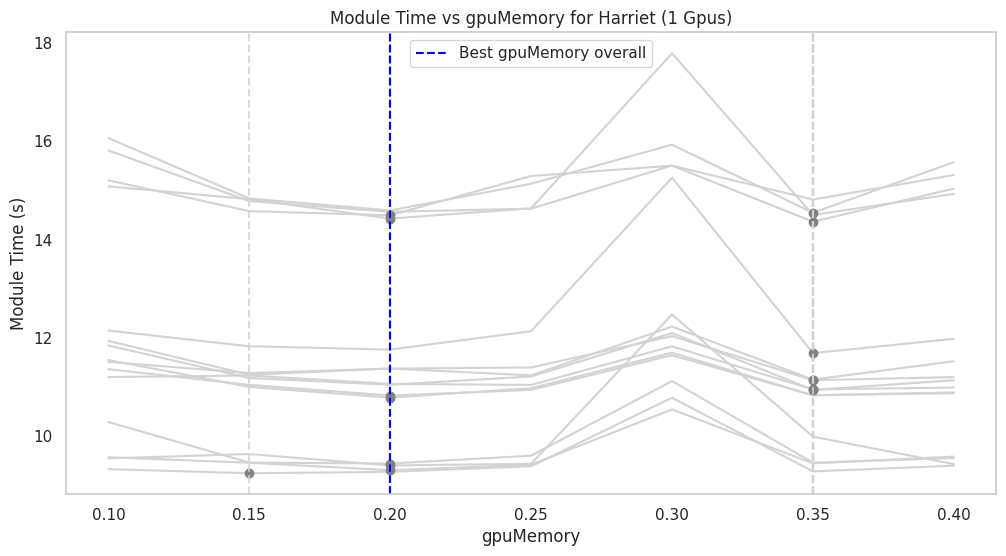

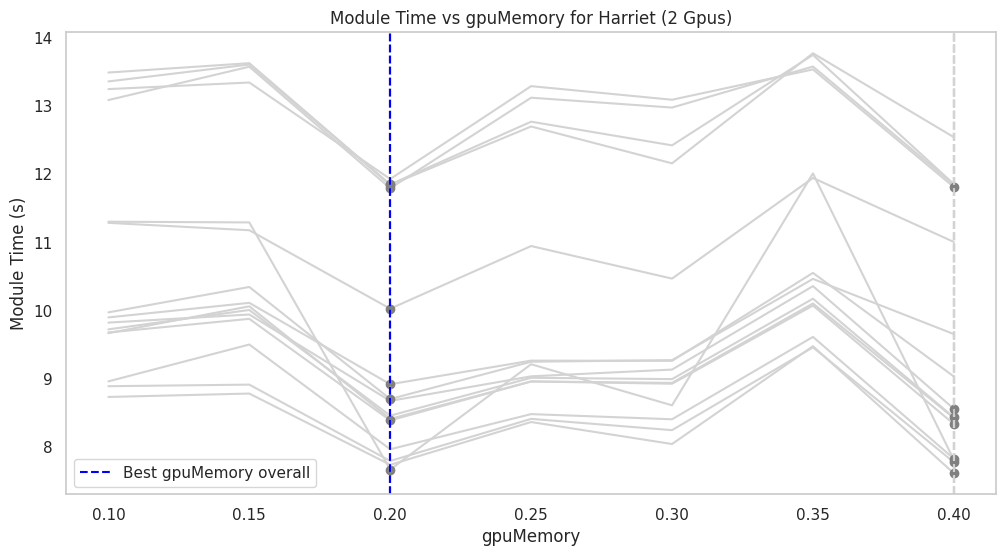

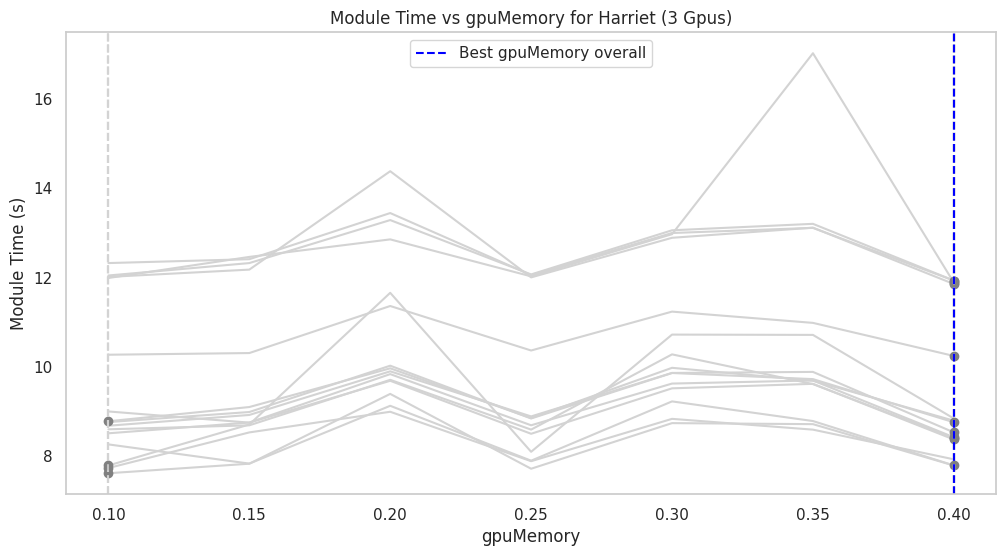

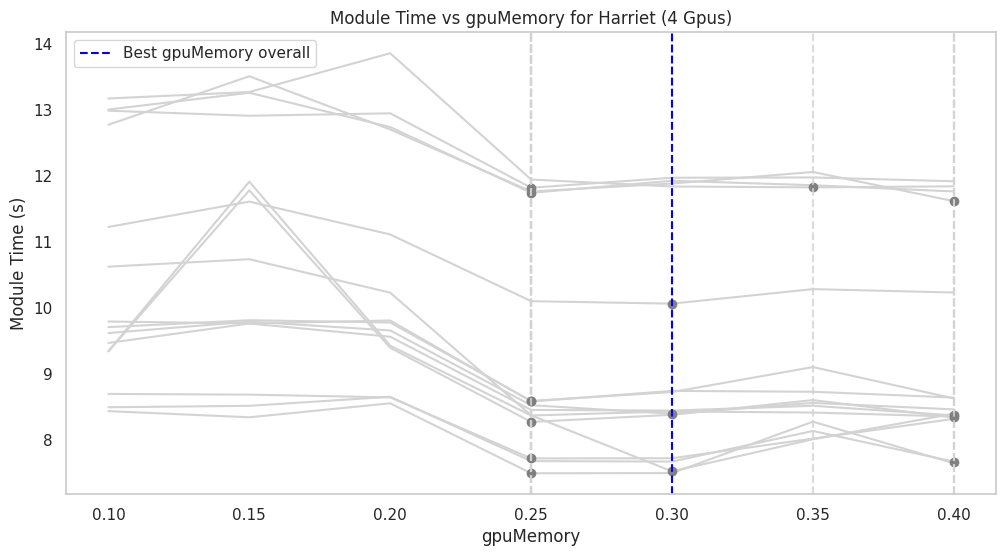

In [46]:
# Dictionary of gpu count to new line position
if(repetitions == 10): 
    new_lines = {1: 0.3, 2: 0.25, 3: 0.4, 4: 0.35}
elif(repetitions ==20):
    new_lines = {1: 0.2, 2: 0.2, 3: 0.4, 4: 0.3}
else:
    new_lines = {1: None, 2:None , 3: None, 4:None}

all_gpus = sorted(new_lines.keys())

# Set style for horizontal grid only
sns.set_style("whitegrid")
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.color"] = "lightgray"

for ngpus in all_gpus:
    df_filtered_1 = df_cuda[df_cuda["Gpus"] == ngpus]
    df_filtered = df_filtered_1[df_filtered_1["Machine"] == "harriet"]
    
    if df_filtered.empty:
        continue  # Skip if no data
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    lineplot = sns.lineplot(
        data=df_filtered,
        x="gpuMemory",
        y="Module Time (s)",
        hue="Operation",
    palette={op: "lightgray" for op in df_filtered["Operation"].unique()},
        ax=ax
    )
    
    # Get line colors by operation
    line_colors = {line.get_label(): line.get_color() for line in ax.get_lines()}
    
    # Plot dots and vertical dashed lines for min points
    for operation, group in df_filtered.groupby("Operation"):
        group_sorted = group.sort_values("gpuMemory")
        min_row = group_sorted.loc[group_sorted["Module Time (s)"].idxmin()]
        x_val = min_row["gpuMemory"]
        y_val = min_row["Module Time (s)"]
        color = line_colors[operation]
        ax.plot(x_val, y_val, "o", color="gray")
        ax.axvline(x=x_val, linestyle="--", color="lightgray", alpha=0.8)

    # Determine monotonic decreasing cutoff
    valid_gpu_mems = sorted(df_filtered["gpuMemory"].unique())
    decreasing_cutoff = None
    for i in range(len(valid_gpu_mems)):
        current_cutoff = valid_gpu_mems[i]
        is_decreasing = True
        for operation, group in df_filtered.groupby("Operation"):
            sub = group.sort_values("gpuMemory")
            sub = sub[sub["gpuMemory"] <= current_cutoff]
            if not all(np.diff(sub["Module Time (s)"]) < 0):
                is_decreasing = False
                break
        if is_decreasing:
            decreasing_cutoff = current_cutoff

    # Add the specific black vertical line for this GPU count
    if(new_lines[ngpus]): ax.axvline(
        x=new_lines[ngpus],
        linestyle="--",
        color="blue",
        label="Best gpuMemory overall"
    )

    # Title and labels
    ax.set_title(f"Module Time vs gpuMemory for Harriet ({ngpus} Gpus)")
    ax.set_xlabel("gpuMemory")
    ax.set_ylabel("Module Time (s)")
    ax.set_xticks(valid_gpu_mems)
    
    # Custom legend: keep only dashed lines (i.e., threshold lines)
    handles, labels = ax.get_legend_handles_labels()
    keep_labels = {"Best gpuMemory overall"}
    new_handles_labels = [
        (h, l) for h, l in zip(handles, labels) if l in keep_labels
    ]
    if new_handles_labels:
        handles, labels = zip(*new_handles_labels)
        ax.legend(
            handles,
            labels,
            title="",
            loc='best',  # Let matplotlib decide the best position
            frameon=True
        )
    if(save): plt.savefig(f"{output_dir}/harriet_{ngpus}gpus_gpuMemory_trends.png", dpi=300, bbox_inches='tight')


#### Faster study

In [107]:
# Filter the data
ngpus = 3
df_gpus = df_cuda[df_cuda["Gpus"] == ngpus]
df_filtered = df_gpus[df_gpus["Machine"] == "harriet"]

# Set the monotonic threshold value
threshold_gpu_mem = 0.4

# Prepare list to collect data
summary_data = []

# Process each operation
for operation, group in df_filtered.groupby("Operation"):
    group_sorted = group.sort_values("gpuMemory")

    # Get the min Module Time and corresponding gpuMemory
    min_row = group_sorted.loc[group_sorted["Module Time (s)"].idxmin()]
    min_time = min_row["Module Time (s)"]
    min_mem = min_row["gpuMemory"]

    # Get the Module Time at the threshold 
    thresh_row = group_sorted[group_sorted["gpuMemory"] == threshold_gpu_mem]
    if thresh_row.empty:
        continue  # Skip if the threshold is not available
    thresh_time = thresh_row["Module Time (s)"].values[0]

    # Compute absolute and relative differences
    abs_diff_us = (thresh_time - min_time) * 1e3  # Convert to miliseconds
    perc_faster = 100 * (1 - min_time / thresh_time)

    # Append to list
    summary_data.append({
        "Operation": operation,
        "Min Time (s)": min_time,
        "Min gpuMemory": min_mem,
        f"Time - {threshold_gpu_mem} gpuMemory (s)": thresh_time,
        "Saved Time (ms)": abs_diff_us,
        "Faster (%)": perc_faster
    })

# Create DataFrame
summary_df = pd.DataFrame(summary_data)

# Round for display
summary_df["Saved Time (ms)"] = summary_df["Saved Time (ms)"].round(2)
summary_df["Faster (%)"] = summary_df["Faster (%)"].round(2)

# Display the table
summary_df = summary_df.sort_values("Faster (%)", ascending=False)

save_df_as_image(summary_df, output_dir+f"/faster_table_{ngpus}gpus_{threshold_gpu_mem}.png", 300, False)

display(summary_df)
summary_df['Saved Time (ms)'].sum() #tempo 'perdido' por não usar o melhor gpu_memory

benchmark_read/Cuda_20reps_plots/faster_table_3gpus_0.4.png


Operation  Min Time (s)  Min gpuMemory  \
5                erosion_binary      7.791717            0.1   
3               dilation_binary      7.734705            0.1   
4            dilation_grayscale      7.617970            0.1   
1                closing_binary      8.783020            0.1   
0                    bottom_hat      8.424239            0.4   
2             closing_grayscale      8.407974            0.4   
6             erosion_grayscale      7.793265            0.4   
7      geodesic_dilation_binary     11.934882            0.4   
8   geodesic_dilation_grayscale     11.935538            0.4   
9       geodesic_erosion_binary     11.889515            0.4   
10   geodesic_erosion_grayscale     11.857777            0.4   
11               opening_binary      8.759762            0.4   
12            opening_grayscale      8.374596            0.4   
13                smooth_binary     10.246288            0.4   
14                      top_hat      8.533452            0.4   

    Time - 0.4 gpuMemory (s)  Saved Time (ms)  Faster (%)  
5                   8.843935          1052.22       11.90  
3                   7.929726           195.02        2.46  
4                   7.790922           172.95        2.22  
1                   8.795313            12.29        0.14  
0                   8.424239             0.00        0.00  
2                   8.407974             0.00        0.00  
6                   7.793265             0.00        0.00  
7                  11.934882             0.00        0.00  
8                  11.935538             0.00        0.00  
9                  11.889515             0.00        0.00  
10                 11.857777             0.00        0.00  
11                  8.759762             0.00        0.00  
12                  8.374596             0.00        0.00  
13                 10.246288             0.00        0.00  
14                  8.533452             0.00        0.00

1432.48

In [45]:
# Get all unique gpuMemory values
gpu_mem_values = sorted(df_filtered["gpuMemory"].unique())

# Prepare the new summary list
summary_data = []

# Process each operation
for operation, group in df_filtered.groupby("Operation"):
    group_sorted = group.sort_values("gpuMemory")

    # Find the minimum time and corresponding memory
    min_row = group_sorted.loc[group_sorted["Module Time (s)"].idxmin()]
    min_time = min_row["Module Time (s)"]
    min_mem = min_row["gpuMemory"]

    # Start with base row
    row = {
        "Operation": operation,
        "Min Time (s)": min_time,
        "Min gpuMemory": min_mem
    }

    # Add Faster (%) columns for each gpuMemory
    for mem in gpu_mem_values:
        mem_row = group_sorted[group_sorted["gpuMemory"] == mem]
        if mem_row.empty:
            row[f"Fast (%) @ {mem}"] = None
        else:
            time = mem_row["Module Time (s)"].values[0]
            row[f"Fast (%) @ {mem}"] = round(100 * (1 - time / min_time), 2)

    summary_data.append(row)

# Create DataFrame
summary_df = pd.DataFrame(summary_data)

# Identify the best gpuMemory: the one with the highest average "Fast (%)" (i.e., closest to 0 or above)
gpu_speed_cols = [col for col in summary_df.columns if col.startswith("Fast (%) @")]
avg_speed_by_mem = summary_df[gpu_speed_cols].mean(numeric_only=True).sort_values(ascending=False)

best_gpu_memory = avg_speed_by_mem.idxmax().replace("Fast (%) @ ", "")
best_speed_gain = avg_speed_by_mem.max()

# Display summary
display(summary_df.sort_values("Operation"))
print(f"\n✅ Best overall gpuMemory setting: {best_gpu_memory} (Avg gain: {best_speed_gain:.2f}%)")

Operation  Min Time (s)  Min gpuMemory  Fast (%) @ 0.1  \
0                    bottom_hat      8.373448           0.40          -13.09   
1                closing_binary      8.592896           0.25          -12.99   
2             closing_grayscale      8.275120           0.25          -12.90   
3               dilation_binary      7.722874           0.25          -12.63   
4            dilation_grayscale      7.498635           0.25          -12.53   
5                erosion_binary      7.527506           0.30          -41.13   
6             erosion_grayscale      7.674069           0.40          -10.72   
7      geodesic_dilation_binary     11.817509           0.25           -9.86   
8   geodesic_dilation_grayscale     11.822931           0.35          -11.37   
9       geodesic_erosion_binary     11.740104           0.25          -10.73   
10   geodesic_erosion_grayscale     11.613593           0.40           -9.95   
11               opening_binary      8.584033           0.25          -14.09   
12            opening_grayscale      8.356473           0.40          -11.81   
13                smooth_binary     10.064082           0.30          -11.52   
14                      top_hat      8.398037           0.30          -14.54   

    Fast (%) @ 0.15  Fast (%) @ 0.2  Fast (%) @ 0.25  Fast (%) @ 0.3  \
0            -16.60          -14.21            -0.99           -0.87   
1            -14.20          -13.80             0.00           -1.56   
2            -42.33          -13.55             0.00           -1.30   
3            -12.49          -11.96             0.00           -0.04   
4            -11.29          -14.10             0.00           -0.03   
5            -42.62          -35.90           -11.27            0.00   
6            -11.00          -12.78            -0.11           -0.02   
7             -9.21           -9.52             0.00           -1.28   
8            -12.20          -17.16            -1.00           -0.11   
9            -12.89           -8.47             0.00           -1.56   
10           -16.28           -9.34            -1.27           -2.30   
11           -13.76          -14.27             0.00           -1.87   
12           -42.51          -12.83            -0.19           -0.94   
13           -15.33          -10.40            -0.37            0.00   
14           -16.60          -15.01            -1.55            0.00   

    Fast (%) @ 0.35  Fast (%) @ 0.4  
0             -1.74            0.00  
1             -5.96           -0.43  
2             -3.99           -0.82  
3             -3.88           -7.76  
4            -10.41           -2.00  
5             -6.45          -11.60  
6             -6.05            0.00  
7             -1.31           -0.83  
8              0.00           -0.13  
9             -0.98           -0.18  
10            -3.81            0.00  
11            -1.72           -0.69  
12            -0.72            0.00  
13            -2.18           -1.67  
14            -1.96           -0.79


✅ Best overall gpuMemory setting: 0.3 (Avg gain: -0.79%)


### Plots Notebook

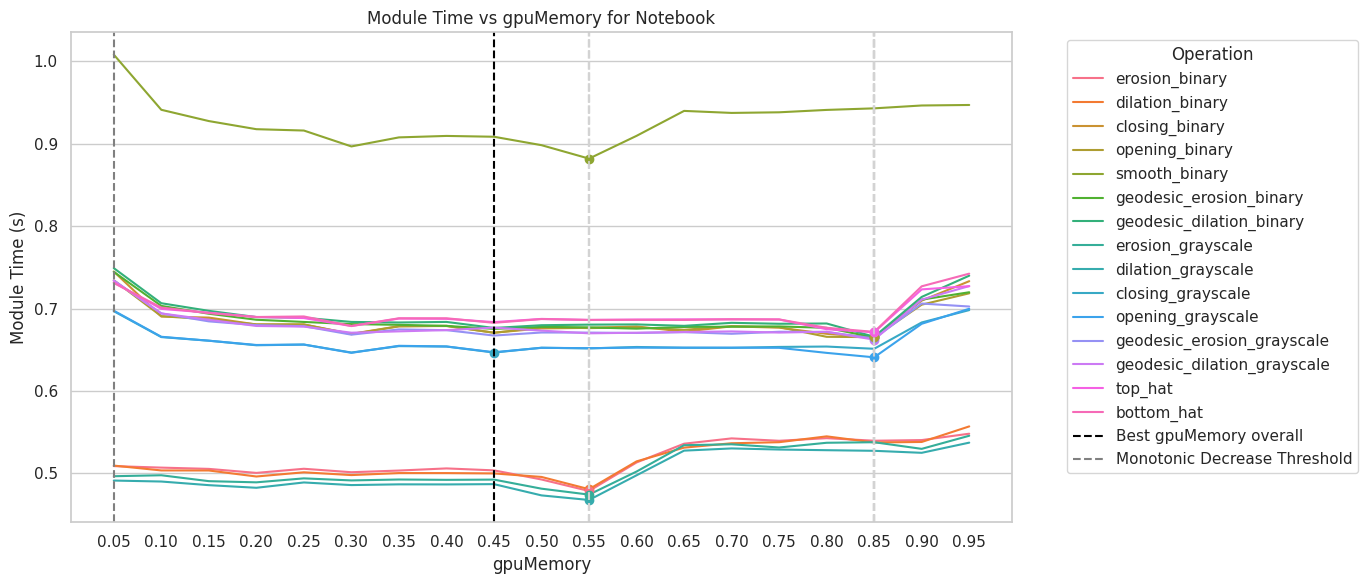

In [47]:
# Filter the data
df_filtered = df_cuda_notebook

# Set style for horizontal grid only
sns.set_style("whitegrid")
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["axes.grid.which"] = "major"

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the main lines (no markers)
lineplot = sns.lineplot(
    data=df_filtered,
    x="gpuMemory",
    y="Module Time (s)",
    hue="Operation",
    ax=ax
)

# Get line colors by operation
line_colors = {line.get_label(): line.get_color() for line in ax.get_lines()}

# Add a dot and a vertical dashed line at the min point for each operation
for operation, group in df_filtered.groupby("Operation"):
    group_sorted = group.sort_values("gpuMemory")
    min_row = group_sorted.loc[group_sorted["Module Time (s)"].idxmin()]
    x_val = min_row["gpuMemory"]
    y_val = min_row["Module Time (s)"]
    color = line_colors[operation]

    # Plot the dot in the same color as the line
    ax.plot(x_val, y_val, "o", color=color)

    # Add a vertical dashed line in light gray
    ax.axvline(x=x_val, linestyle="--", color="lightgray", alpha=0.8)

# 🔍 Determine the largest gpuMemory value where all operations decrease up to that point
valid_gpu_mems = sorted(df_filtered["gpuMemory"].unique())
decreasing_cutoff = None

for i in range(len(valid_gpu_mems)):
    current_cutoff = valid_gpu_mems[i]
    is_decreasing = True
    for operation, group in df_filtered.groupby("Operation"):
        sub = group.sort_values("gpuMemory")
        sub = sub[sub["gpuMemory"] <= current_cutoff]
        if not all(np.diff(sub["Module Time (s)"]) < 0):
            is_decreasing = False
            break
    if is_decreasing:
        decreasing_cutoff = current_cutoff

# Add the specific black vertical line for this GPU count
ax.axvline(
    x=0.45,
    linestyle="--",
    color="black",
    label="Best gpuMemory overall"
)

# 🔲 Add black dashed line if found
if decreasing_cutoff is not None:
    black_line = ax.axvline(
        x=decreasing_cutoff,
        linestyle="--",
        color="gray",
        label="Monotonic Decrease Threshold"
    )

# Title and labels
ax.set_title('Module Time vs gpuMemory for Notebook')
ax.set_xlabel("gpuMemory")
ax.set_ylabel("Module Time (s)")
ax.set_xticks(valid_gpu_mems)

# 🎯 Custom legend with operations and threshold line
handles, labels = ax.get_legend_handles_labels()
unique_ops = df_filtered["Operation"].unique().tolist()
new_handles_labels = [
    (h, l) for h, l in zip(handles, labels)
    if l in unique_ops or l in {"Monotonic Decrease Threshold", "Best gpuMemory overall"}
]
if new_handles_labels:
    handles, labels = zip(*new_handles_labels)
    ax.legend(handles, labels, title="Operation", loc='upper left', bbox_to_anchor=(1.05, 1))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.85)
if(save): plt.savefig(f"{output_dir}/notebook_gpuMemory.png", dpi=300, bbox_inches='tight')
plt.show()

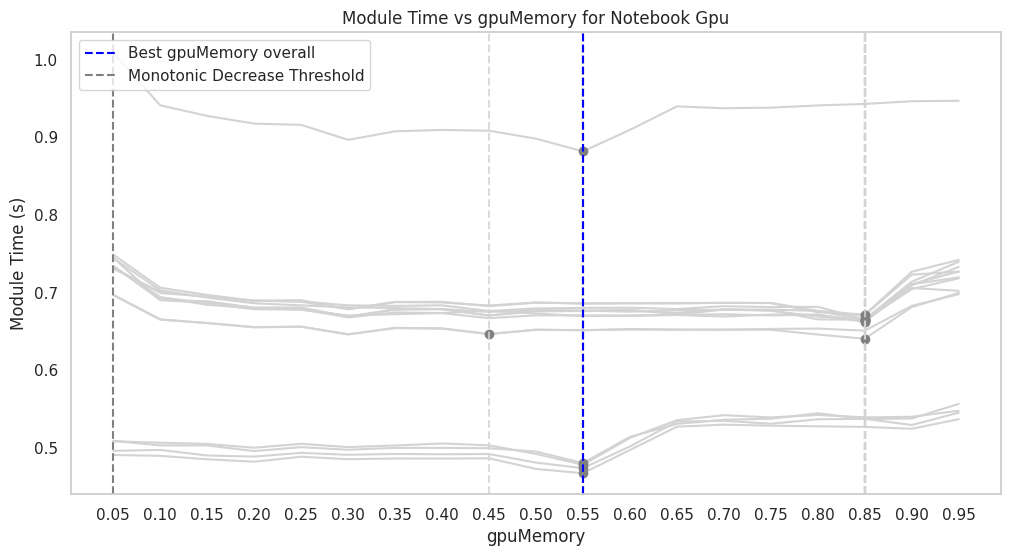

In [48]:
# Set style for horizontal grid only
sns.set_style("whitegrid")
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.color"] = "lightgray"

df_filtered = df_cuda_notebook

fig, ax = plt.subplots(figsize=(12, 6))

lineplot = sns.lineplot(
    data=df_filtered,
    x="gpuMemory",
    y="Module Time (s)",
    hue="Operation",
palette={op: "lightgray" for op in df_filtered["Operation"].unique()},
    ax=ax
)

# Get line colors by operation
line_colors = {line.get_label(): line.get_color() for line in ax.get_lines()}

# Plot dots and vertical dashed lines for min points
for operation, group in df_filtered.groupby("Operation"):
    group_sorted = group.sort_values("gpuMemory")
    min_row = group_sorted.loc[group_sorted["Module Time (s)"].idxmin()]
    x_val = min_row["gpuMemory"]
    y_val = min_row["Module Time (s)"]
    color = line_colors[operation]
    ax.plot(x_val, y_val, "o", color="gray")
    ax.axvline(x=x_val, linestyle="--", color="lightgray", alpha=0.8)

# Determine monotonic decreasing cutoff
valid_gpu_mems = sorted(df_filtered["gpuMemory"].unique())
decreasing_cutoff = None
for i in range(len(valid_gpu_mems)):
    current_cutoff = valid_gpu_mems[i]
    is_decreasing = True
    for operation, group in df_filtered.groupby("Operation"):
        sub = group.sort_values("gpuMemory")
        sub = sub[sub["gpuMemory"] <= current_cutoff]
        if not all(np.diff(sub["Module Time (s)"]) < 0):
            is_decreasing = False
            break
    if is_decreasing:
        decreasing_cutoff = current_cutoff

# Add the specific black vertical line for this GPU count
ax.axvline(
    x=0.55,
    linestyle="--",
    color="blue",
    label="Best gpuMemory overall"
)

# 🔲 Add black dashed line if found
if decreasing_cutoff is not None:
    black_line = ax.axvline(
        x=decreasing_cutoff,
        linestyle="--",
        color="gray",
        label="Monotonic Decrease Threshold"
    )

# Title and labels
ax.set_title(f"Module Time vs gpuMemory for Notebook Gpu")
ax.set_xlabel("gpuMemory")
ax.set_ylabel("Module Time (s)")
ax.set_xticks(valid_gpu_mems)

# Custom legend: keep only dashed lines (i.e., threshold lines)
handles, labels = ax.get_legend_handles_labels()
keep_labels = {"Monotonic Decrease Threshold", "Best gpuMemory overall"}
new_handles_labels = [
    (h, l) for h, l in zip(handles, labels) if l in keep_labels
]
if new_handles_labels:
    handles, labels = zip(*new_handles_labels)
    ax.legend(
        handles,
        labels,
        title="",
        loc='best',  # Let matplotlib decide the best position
        frameon=True
    )
if(save): plt.savefig(f"{output_dir}/notebook_gpuMemory_trends.png", dpi=300, bbox_inches='tight')


In [49]:
# Set the monotonic threshold value
threshold_gpu_mem = 0.55

# Prepare list to collect data
summary_data = []

# Process each operation
for operation, group in df_filtered.groupby("Operation"):
    group_sorted = group.sort_values("gpuMemory")

    # Get the min Module Time and corresponding gpuMemory
    min_row = group_sorted.loc[group_sorted["Module Time (s)"].idxmin()]
    min_time = min_row["Module Time (s)"]
    min_mem = min_row["gpuMemory"]

    # Get the Module Time at the threshold (gpuMemory == 0.2)
    thresh_row = group_sorted[group_sorted["gpuMemory"] == threshold_gpu_mem]
    if thresh_row.empty:
        continue  # Skip if the threshold is not available
    thresh_time = thresh_row["Module Time (s)"].values[0]

    # Compute absolute and relative differences
    abs_diff_us = (thresh_time - min_time) * 1e3  # Convert to microseconds
    perc_faster = 100 * (1 - min_time / thresh_time)

    # Append to list
    summary_data.append({
        "Operation": operation,
        "Min Time (s)": min_time,
        "Min gpuMemory": min_mem,
        "Time - 0.45 gpuMemory (s)": thresh_time,
        "Saved Time (ms)": abs_diff_us,
        "Faster (%)": perc_faster
    })

# Create DataFrame
summary_df = pd.DataFrame(summary_data)

# Round for display
summary_df["Saved Time (ms)"] = summary_df["Saved Time (ms)"].round(2)
summary_df["Faster (%)"] = summary_df["Faster (%)"].round(2)

# Display the table
summary_df = summary_df.sort_values("Faster (%)", ascending=False)
display(summary_df)
summary_df['Saved Time (ms)'].sum()

Operation  Min Time (s)  Min gpuMemory  \
14                      top_hat      0.671165           0.85   
7      geodesic_dilation_binary      0.665740           0.85   
0                    bottom_hat      0.671612           0.85   
9       geodesic_erosion_binary      0.664897           0.85   
1                closing_binary      0.665045           0.85   
12            opening_grayscale      0.640761           0.85   
11               opening_binary      0.665254           0.85   
8   geodesic_dilation_grayscale      0.662183           0.85   
10   geodesic_erosion_grayscale      0.663677           0.85   
2             closing_grayscale      0.646556           0.45   
3               dilation_binary      0.480727           0.55   
4            dilation_grayscale      0.467622           0.55   
5                erosion_binary      0.478540           0.55   
6             erosion_grayscale      0.474126           0.55   
13                smooth_binary      0.881924           0.55   

    Time - 0.45 gpuMemory (s)  Saved Time (ms)  Faster (%)  
14                   0.686174            15.01        2.19  
7                    0.680438            14.70        2.16  
0                    0.686091            14.48        2.11  
9                    0.677103            12.21        1.80  
1                    0.676518            11.47        1.70  
12                   0.651857            11.10        1.70  
11                   0.676265            11.01        1.63  
8                    0.669894             7.71        1.15  
10                   0.670782             7.11        1.06  
2                    0.651572             5.02        0.77  
3                    0.480727             0.00        0.00  
4                    0.467622             0.00        0.00  
5                    0.478540             0.00        0.00  
6                    0.474126             0.00        0.00  
13                   0.881924             0.00        0.00

109.82

In [50]:
# Get all unique gpuMemory values
gpu_mem_values = sorted(df_filtered["gpuMemory"].unique())

# Prepare the new summary list
summary_data = []

# Process each operation
for operation, group in df_filtered.groupby("Operation"):
    group_sorted = group.sort_values("gpuMemory")

    # Find the minimum time and corresponding memory
    min_row = group_sorted.loc[group_sorted["Module Time (s)"].idxmin()]
    min_time = min_row["Module Time (s)"]
    min_mem = min_row["gpuMemory"]

    # Start with base row
    row = {
        "Operation": operation,
        "Min Time (s)": min_time,
        "Min gpuMemory": min_mem
    }

    # Add Faster (%) columns for each gpuMemory
    for mem in gpu_mem_values:
        mem_row = group_sorted[group_sorted["gpuMemory"] == mem]
        if mem_row.empty:
            row[f"Fast (%) @ {mem}"] = None
        else:
            time = mem_row["Module Time (s)"].values[0]
            row[f"Fast (%) @ {mem}"] = round(100 * (1 - time / min_time), 2)

    summary_data.append(row)

# Create DataFrame
summary_df = pd.DataFrame(summary_data)

# Identify the best gpuMemory: the one with the highest average "Fast (%)" (i.e., closest to 0 or above)
gpu_speed_cols = [col for col in summary_df.columns if col.startswith("Fast (%) @")]
avg_speed_by_mem = summary_df[gpu_speed_cols].mean(numeric_only=True).sort_values(ascending=False)

best_gpu_memory = avg_speed_by_mem.idxmax().replace("Fast (%) @ ", "")
best_speed_gain = avg_speed_by_mem.max()

# Display summary
display(summary_df.sort_values("Operation"))
print(f"\n✅ Best overall gpuMemory setting: {best_gpu_memory} (Avg gain: {best_speed_gain:.2f}%)")

Operation  Min Time (s)  Min gpuMemory  Fast (%) @ 0.05  \
0                    bottom_hat      0.671612           0.85            -8.84   
1                closing_binary      0.665045           0.85           -12.01   
2             closing_grayscale      0.646556           0.45            -7.76   
3               dilation_binary      0.480727           0.55            -5.95   
4            dilation_grayscale      0.467622           0.55            -5.04   
5                erosion_binary      0.478540           0.55            -6.31   
6             erosion_grayscale      0.474126           0.55            -4.71   
7      geodesic_dilation_binary      0.665740           0.85           -12.51   
8   geodesic_dilation_grayscale      0.662183           0.85           -10.82   
9       geodesic_erosion_binary      0.664897           0.85           -11.98   
10   geodesic_erosion_grayscale      0.663677           0.85           -10.61   
11               opening_binary      0.665254           0.85           -10.38   
12            opening_grayscale      0.640761           0.85            -8.84   
13                smooth_binary      0.881924           0.55           -14.31   
14                      top_hat      0.671165           0.85            -9.00   

    Fast (%) @ 0.1  Fast (%) @ 0.15  Fast (%) @ 0.2  Fast (%) @ 0.25  \
0            -4.40            -3.40           -2.69            -2.79   
1            -3.80            -3.60           -2.35            -2.35   
2            -2.90            -2.23           -1.37            -1.49   
3            -4.73            -4.72           -3.20            -4.26   
4            -4.79            -3.85           -3.17            -4.55   
5            -5.93            -5.61           -4.59            -5.63   
6            -4.96            -3.45           -3.15            -4.16   
7            -6.11            -4.72           -3.59            -3.47   
8            -4.81            -3.65           -2.51            -2.40   
9            -5.76            -4.33           -3.23            -2.83   
10           -4.57            -3.12           -2.43            -2.24   
11           -3.82            -3.24           -2.32            -2.31   
12           -3.89            -3.15           -2.34            -2.42   
13           -6.72            -5.17           -4.05            -3.86   
14           -4.23            -3.54           -2.76            -2.57   

    Fast (%) @ 0.3  Fast (%) @ 0.35  ...  Fast (%) @ 0.5  Fast (%) @ 0.55  \
0            -1.07            -2.46  ...           -2.32            -2.16   
1            -0.62            -2.04  ...           -1.62            -1.73   
2            -0.00            -1.20  ...           -0.91            -0.78   
3            -3.56            -4.07  ...           -3.09             0.00   
4            -3.87            -4.06  ...           -1.19             0.00   
5            -4.76            -5.18  ...           -2.92             0.00   
6            -3.63            -3.87  ...           -1.52             0.00   
7            -2.70            -2.60  ...           -2.10            -2.21   
8            -1.28            -1.52  ...           -1.66            -1.16   
9            -2.43            -2.30  ...           -1.92            -1.84   
10           -0.69            -1.65  ...           -1.08            -1.07   
11           -0.55            -1.96  ...           -1.78            -1.66   
12           -0.85            -2.18  ...           -1.80            -1.73   
13           -1.68            -2.92  ...           -1.85             0.00   
14           -1.12            -2.48  ...           -2.42            -2.24   

    Fast (%) @ 0.6  Fast (%) @ 0.65  Fast (%) @ 0.7  Fast (%) @ 0.75  \
0            -2.17            -2.16           -2.28            -2.25   
1            -1.98            -1.03           -2.00            -1.76   
2            -1.05            -0.90           -0.88            -1.06   
3            -7.02           -10.49          -11.60


✅ Best overall gpuMemory setting: 0.55 (Avg gain: -1.11%)


## Compare cython and cuda tests

In [52]:
df_compare = df_cython2[['Operation', 'Machine', 'Gpus', 'gpuMemory', 'Module Time (s)','Repetitions', 
                 'Image Data Type', 'Image Size (MB)', 'Image Dimensions']].copy()
#df_compare = df_cython[df_cython['Machine']=='notebook']
df_compare.rename(columns={'Module Time (s)': 'Cython Time (s)'}, inplace=True)

# Define the mapping dictionary
operation_mapping = {
    'Smoothing 3D binary': 'smooth_binary',
    'Opening 3D binary': 'opening_binary',
    'Erosion 3D grayscale': 'erosion_grayscale',
    'Erosion 3D binary': 'erosion_binary',
    'Closing 3D binary': 'closing_binary',
    'Dilation 3D grayscale': 'dilation_grayscale',
    'Closing 3D grayscale': 'closing_grayscale',
    'Dilation 3D binary': 'dilation_binary',
    'Opening 3D grayscale': 'opening_grayscale',
}

# Apply the mapping to your DataFrame
df_compare['Operation'] = df_compare['Operation'].map(operation_mapping)

In [53]:
df_cuda_compare = df_cuda.copy()
#df_cuda_compare = df_cuda_compare[df_cuda_compare['Machine']=='notebook']
df_cuda_compare.rename(columns={'Module Time (s)': 'Cuda Time (s)'}, inplace=True)

In [54]:
# Merge on multiple columns
merged_df = pd.merge(df_compare,df_cuda_compare, on=['Operation', 'Machine', 'Gpus', 'gpuMemory','Image Data Type','Image Dimensions', 'Image Size (MB)'])
merged_df = merged_df[['Operation', 'Machine', 'Gpus', 'gpuMemory', 'Cython Time (s)','Cuda Time (s)',
                       'Image Data Type', 'Image Size (MB)', 'Image Dimensions']]
merged_df.sort_values(by=['Gpus', 'Operation'], inplace=True)

In [55]:
merged_df['Time Ratio (%)'] = (merged_df['Cython Time (s)'] / merged_df['Cuda Time (s)']).round(3) *100
merged_df['Time Difference (s)'] = (merged_df['Cython Time (s)'] - merged_df['Cuda Time (s)']).round(3)

In [59]:
notebook_df = filter_dataframe(merged_df,{'Machine': 'notebook'})
grouped_description = notebook_df.groupby('Operation')[['Time Ratio (%)','Time Difference (s)']].agg(['mean', 'std','min', 'max']).round(2)
grouped_description.sort_values(('Time Ratio (%)', 'mean'), ascending=True)
save_df_as_image(grouped_description, output_dir+"/compare_table_notebook.png")
grouped_description

Time Ratio (%)                     Time Difference (s)  \
                             mean   std    min    max                mean   
Operation                                                                   
closing_binary             118.36  2.31  113.4  124.0                0.12   
closing_grayscale          119.48  2.16  113.0  123.6                0.13   
dilation_binary            124.83  2.62  119.5  130.0                0.13   
dilation_grayscale         126.32  2.41  121.7  130.3                0.13   
erosion_binary             125.46  2.64  122.2  133.1                0.13   
erosion_grayscale          127.51  6.20  122.0  149.1                0.14   
opening_binary             118.46  1.51  114.4  120.5                0.13   
opening_grayscale          119.84  2.00  114.7  124.4                0.13   
smooth_binary              113.79  1.02  112.0  115.7                0.13   

                                      
                     std   min   max  
Operation                             
closing_binary      0.02  0.09  0.16  
closing_grayscale   0.01  0.08  0.15  
dilation_binary     0.01  0.11  0.15  
dilation_grayscale  0.01  0.11  0.15  
erosion_binary      0.01  0.12  0.17  
erosion_grayscale   0.03  0.12  0.24  
opening_binary      0.01  0.10  0.14  
opening_grayscale   0.01  0.10  0.16  
smooth_binary       0.01  0.11  0.14

In [119]:
ngpus = 2
harriet_df = filter_dataframe(merged_df,{'Machine': 'harriet', 'Gpus':ngpus, ''})
grouped_description = harriet_df.groupby('Operation')[['Time Ratio (%)','Time Difference (s)']].agg(['mean', 'median','std','min', 'max']).round(2)
grouped_description.sort_values(('Time Ratio (%)', 'mean'), ascending=True)
save_df_as_image(grouped_description, output_dir+f"/compare_table_harriet_{ngpus}gpus.png")
grouped_description

benchmark_read/Cuda_20reps_plots/compare_table_harriet_2gpus.png


Time Ratio (%)                              \
                             mean median    std    min    max   
Operation                                                       
closing_binary             233.06  243.6  29.94  178.8  273.6   
closing_grayscale          229.81  231.7  27.45  180.0  266.1   
dilation_binary            224.10  226.7  27.89  170.4  253.8   
dilation_grayscale         218.56  225.2  29.63  158.2  254.9   
erosion_binary             200.23  193.3  33.53  151.6  255.4   
erosion_grayscale          229.99  234.3  28.64  178.6  260.3   
opening_binary             232.64  240.5  20.39  205.0  253.2   
opening_grayscale          218.37  228.9  33.91  167.4  268.1   
smooth_binary              219.49  225.7  17.08  195.6  243.2   

                   Time Difference (s)                             
                                  mean median   std    min    max  
Operation                                                          
closing_binary                   12.65  12.98  2.54   8.32  15.49  
closing_grayscale                11.83  12.37  2.02   8.06  13.98  
dilation_binary                  10.71  11.11  2.37   6.77  14.28  
dilation_grayscale                9.82  10.22  2.12   5.52  11.99  
erosion_binary                    9.31   9.44  2.01   6.20  11.92  
erosion_grayscale                10.97  11.08  2.25   7.44  13.75  
opening_binary                   12.78  13.04  1.80   9.71  15.22  
opening_grayscale                10.79  11.53  2.71   6.04  14.11  
smooth_binary                    13.08  14.19  1.61  10.46  14.36

## Erro na operação cudaMemcpy(deviceToHost)



O parâmetro gpuMemory controla o quanto da memorória livre da gpu pode ser usado para alocar a imagem de entrada e suas cópias. A parir desse parâmetro, da memória livre e do númeor de cópias do input usado pela função, calcula-se o tamanho máximo do chunk. 
Em testes locais, usando a gpu do notebook, é possível operar com gpuMemory próximo de 1. É precisa fechar todas as demais janelas e manter apenas o terminal aberto para que o sistema operacional não mate o processo (pois a gpu também é usada para renderizar a interface gráfica e o sistema fica sobrecarregado).
Nos testes remotos feitos na Harriet, não é possível aumentar o parâmetro gpuMemory. Para a imagem média (1520, 1520, 600) o valor máximo da gpuMemory que é possível executar o código é 0.41. Para a imagem grande (2048, 2052, 2052) esse valor cai para 0.2, podendo variar a depender da operação e do tipo de dado.
Especialmente para a imagem grande (2048, 2052, 2052) e operações de erosão e dilatação em dados uint8 surgiam erros de 'segmentation fault' para qualquer valor de gpuMemory. Nos demais tipos de dados, surgia erro recorrente na função cudaMemcpy(deviceToHost), especificamente quando copiava-se o resultado final de algum chunk do device para o host a partir de um determinado valor de gpuMemory.
Foram identificadas duas hipóteses de problema:
1) **Dados não emparelhados na memória** - como o tipo de dado uint8 ocupa apenas 1 byte, poderia estar alocado na memória fora do padrão esperado pelas funções cuda e, por isso, surgia o erro 'segmentation fault'.
**Proposta de solução:** alocar os dado no host para testes com funções cuda (cudaMallocHost), pois a função lidaria internamente com esse problema.

2) **Taxa de transferência de dados maior do que a permitida para a função cudaMemcpy(deviceToHost)** 
**Proposta de solução:** copiar os dados em chunks ainda menores de volta para o host.

Foram realizados testes implementando cada uma dessas soluções separadamente e juntas para imagens uint8 e uint16 e os valores de gpuMemory 0.4 e 0.9

### Resultados:

#### CudaMallocHost 
**uint8:**  Funcionou para gpuMemory 0.4 e 0.9.
**uint16:** Não funcionou para gpuMemory 0.4, 0.9 não foi testado.

#### CopyChunks
**uint8:** Não funcionou para gpuMemory 0.4 nem 0.9.
**uint16:** Funcionou para gpuMemory 0.4, e não funcionou para 0.9.

#### CudaMallocHost + CopyChunks 
**uint8:**  Não funcionou para gpuMemory 0.4 nem 0.9.
**uint16:** Funcionou para gpuMemory 0.4 e 0.9

### Conclusão
As soluçoes foram inconclusivas, porque funcionavam para um tipo de dado e para outro não. Não foram implementadas ainda.